# FomulaBEAT

4-1-4からの変更点
- データを空白を削除したもの、さらに深さは1-3（03-3）
- 次元を16次元にする



In [1]:
version = '04-1-5'
model_dir = './model/' + version
data_path = 'data/eq03-4.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['+2++974', '4', '+++0151'] ['297+4++', '4', '01+5+1+']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13, '+': 14}


In [9]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[12, 14, 10, 14, 10, 1, 10, 5, 10, 14, 10, 8, 10, 5, 13]

In [10]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  5, 13])
Output: tensor([12,  5, 13])
元に戻した文章
Input: 5
Output: 5


In [11]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [12]:
len(train_data)

80000

Transoformerの設定

In [13]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [14]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [15]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [16]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [17]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [18]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [19]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 16
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [20]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 16, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)


In [21]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


13 層

層名: token_embedding.embedding.weight
形状: torch.Size([15, 16])
値: Parameter containing:
tensor([[-0.3127, -0.4321,  0.0823,  0.1124, -0.2552,  0.1185,  0.3347, -0.3940,  0.2254,  0.3386,
          0.4085, -0.1205, -0.1517, -0.1134,  0.2144, -0.1394],
        [ 0.1859,  0.4080, -0.2645, -0.0678, -0.4153, -0.3297,  0.0354, -0.1861, -0.0360,  0.2620,
          0.0053, -0.0832, -0.1438, -0.0508, -0.0348, -0.2308],
        [ 0.1286, -0.3086,  0.1752,  0.1941, -0.4275,  0.2817, -0.3009, -0.1628, -0.1690, -0.0332,
          0.2626,  0.1870, -0.3103, -0.2015, -0.0580, -0.0783],
        [-0.1647, -0.3144, -0.0632,  0.0287, -0.2051,  0.3403, -0.2684,  0.0521, -0.2594, -0.2433,
          0.3106, -0.0125,  0.3601,  0.3769,  0.2214,  0.1727],
        [-0.4033,  0.1689,  0.3309,  0.3313, -0.0214,  0.0508,  0.0006,  0.3822, -0.1655, -0.2599,
         -0.1656,  0.0686, -0.3074,  0.2418,  0.0153, -0.2408],
        [-0.1625, -0.0510,  0.1646, -0.4397,  0.4123,  0.3895, -0.1635, -0.0563, -0.0800,  0

## 学習実行

In [22]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

  0%|          | 0/79 [00:00<?, ?it/s]

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 79/79 [00:01<00:00, 58.28it/s]


[1/100] train loss: 2.34, valid loss: 2.06  [1s] counter: 0 **


100%|██████████| 79/79 [00:01<00:00, 67.81it/s]


[2/100] train loss: 1.91, valid loss: 1.81  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.35it/s]


[3/100] train loss: 1.73, valid loss: 1.67  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.21it/s]


[4/100] train loss: 1.63, valid loss: 1.58  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.13it/s]


[5/100] train loss: 1.52, valid loss: 1.46  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.33it/s]


[6/100] train loss: 1.41, valid loss: 1.37  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.33it/s]


[7/100] train loss: 1.31, valid loss: 1.24  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.36it/s]


[8/100] train loss: 1.17, valid loss: 1.17  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.52it/s]


[9/100] train loss: 1.11, valid loss: 1.06  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.81it/s]


[10/100] train loss: 1.03, valid loss: 1.01  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.76it/s]


[11/100] train loss: 0.98, valid loss: 0.96  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.32it/s]


[12/100] train loss: 0.93, valid loss: 0.90  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.28it/s]


[13/100] train loss: 0.88, valid loss: 0.85  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.26it/s]


[14/100] train loss: 0.82, valid loss: 0.80  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.77it/s]


[15/100] train loss: 0.77, valid loss: 0.75  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.18it/s]


[16/100] train loss: 0.72, valid loss: 0.69  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.67it/s]


[17/100] train loss: 0.66, valid loss: 0.63  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 66.42it/s]


[18/100] train loss: 0.60, valid loss: 0.57  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.31it/s]


[19/100] train loss: 0.53, valid loss: 0.50  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.56it/s]


[20/100] train loss: 0.50, valid loss: 0.46  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.61it/s]


[21/100] train loss: 0.44, valid loss: 0.42  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.27it/s]


[22/100] train loss: 0.40, valid loss: 0.39  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.00it/s]


[23/100] train loss: 0.37, valid loss: 0.35  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.93it/s]


[24/100] train loss: 0.34, valid loss: 0.33  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.84it/s]


[25/100] train loss: 0.31, valid loss: 0.30  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.09it/s]


[26/100] train loss: 0.29, valid loss: 0.28  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.06it/s]


[27/100] train loss: 0.27, valid loss: 0.26  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.54it/s]


[28/100] train loss: 0.25, valid loss: 0.24  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.47it/s]


[29/100] train loss: 0.23, valid loss: 0.23  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.20it/s]


[30/100] train loss: 0.27, valid loss: 0.22  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.60it/s]


[31/100] train loss: 0.21, valid loss: 0.20  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.60it/s]


[32/100] train loss: 0.20, valid loss: 0.20  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.41it/s]


[33/100] train loss: 0.19, valid loss: 0.19  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.28it/s]


[34/100] train loss: 0.18, valid loss: 0.18  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.60it/s]


[35/100] train loss: 0.17, valid loss: 0.17  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.17it/s]


[36/100] train loss: 0.17, valid loss: 0.16  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.97it/s]


[37/100] train loss: 0.16, valid loss: 0.16  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.68it/s]


[38/100] train loss: 0.15, valid loss: 0.16  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.13it/s]


[39/100] train loss: 0.15, valid loss: 0.15  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.48it/s]


[40/100] train loss: 0.14, valid loss: 0.14  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.65it/s]


[41/100] train loss: 0.14, valid loss: 0.14  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.73it/s]


[42/100] train loss: 0.13, valid loss: 0.13  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.20it/s]


[43/100] train loss: 0.13, valid loss: 0.13  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.91it/s]


[44/100] train loss: 0.13, valid loss: 0.13  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.78it/s]


[45/100] train loss: 0.12, valid loss: 0.12  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.54it/s]


[46/100] train loss: 0.12, valid loss: 0.12  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.83it/s]


[47/100] train loss: 0.12, valid loss: 0.12  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.53it/s]


[48/100] train loss: 0.11, valid loss: 0.11  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.63it/s]


[49/100] train loss: 0.14, valid loss: 0.37  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 70.67it/s]


[50/100] train loss: 0.14, valid loss: 0.11  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.75it/s]


[51/100] train loss: 0.11, valid loss: 0.11  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.81it/s]


[52/100] train loss: 0.10, valid loss: 0.11  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.00it/s]


[53/100] train loss: 0.10, valid loss: 0.11  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 70.76it/s]


[54/100] train loss: 0.10, valid loss: 0.10  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 70.83it/s]


[55/100] train loss: 0.10, valid loss: 0.10  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.65it/s]


[56/100] train loss: 0.10, valid loss: 0.10  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.81it/s]


[57/100] train loss: 0.10, valid loss: 0.10  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.84it/s]


[58/100] train loss: 0.10, valid loss: 0.10  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 70.79it/s]


[59/100] train loss: 0.10, valid loss: 0.10  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 70.62it/s]


[60/100] train loss: 0.09, valid loss: 0.10  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 70.85it/s]


[61/100] train loss: 0.09, valid loss: 0.10  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 70.99it/s]


[62/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 70.82it/s]


[63/100] train loss: 0.09, valid loss: 0.10  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 70.94it/s]


[64/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 70.74it/s]


[65/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.79it/s]


[66/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 70.81it/s]


[67/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 71.02it/s]


[68/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 69.75it/s]


[69/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.46it/s]


[70/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.94it/s]


[71/100] train loss: 0.08, valid loss: 0.09  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.11it/s]


[72/100] train loss: 0.08, valid loss: 0.09  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.79it/s]


[73/100] train loss: 0.20, valid loss: 0.09  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 70.84it/s]


[74/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 70.75it/s]


[75/100] train loss: 0.09, valid loss: 0.09  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 70.79it/s]


[76/100] train loss: 0.08, valid loss: 0.09  [1s] counter: 4 **


100%|██████████| 79/79 [00:01<00:00, 71.03it/s]


[77/100] train loss: 0.08, valid loss: 0.09  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.70it/s]


[78/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.79it/s]


[79/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.82it/s]


[80/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.65it/s]


[81/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 68.10it/s]


[82/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.22it/s]


[83/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 70.35it/s]


[84/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 69.97it/s]


[85/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 68.20it/s]


[86/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 70.08it/s]


[87/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.03it/s]


[88/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.27it/s]


[89/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 68.36it/s]


[90/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 69.86it/s]


[91/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 68.61it/s]


[92/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.47it/s]


[93/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 69.76it/s]


[94/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 4 **


100%|██████████| 79/79 [00:01<00:00, 69.86it/s]


[95/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.44it/s]


[96/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.41it/s]


[97/100] train loss: 0.08, valid loss: 0.08  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 68.74it/s]


[98/100] train loss: 0.07, valid loss: 0.08  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 69.31it/s]


[99/100] train loss: 0.07, valid loss: 0.08  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 69.56it/s]


[100/100] train loss: 0.07, valid loss: 0.08  [1s] counter: 1 


学習したモデルの保存

In [23]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [24]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.compute_output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [25]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: + + 1 5 + 8 5
Output: 


In [55]:
# 様々な入力を試してみる

text_list = {
'++15+85':'15+85++',
'++16+86':'16+86++',
'++95+71':'95+71++',
'++65+79':'65+79++',
'++92+60':'92+60++'}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input: {text}")
    print(f"Output: {translation}")
    print(f"Target: {tgt}")
    print('---')


Input: ++15+85
Output: 158+5++
Target: 15+85++
---
Input: ++16+86
Output: 168++6+
Target: 16+86++
---
Input: ++95+71
Output: 957+1++
Target: 95+71++
---
Input: ++65+79
Output: 657+9++
Target: 65+79++
---
Input: ++92+60
Output: 926+0++
Target: 92+60++
---


## モデルの動作を分析

In [56]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 16, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)

In [57]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([15, 16])
decoder_layer.self_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.self_attn.in_proj_bias torch.Size([48])
decoder_layer.self_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.self_attn.out_proj.bias torch.Size([16])
decoder_layer.multihead_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.multihead_attn.in_proj_bias torch.Size([48])
decoder_layer.multihead_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.multihead_attn.out_proj.bias torch.Size([16])
decoder_layer.norm1.weight torch.Size([16])
decoder_layer.norm1.bias torch.Size([16])
decoder_layer.norm2.weight torch.Size([16])
decoder_layer.norm2.bias torch.Size([16])


In [58]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data


# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data


In [59]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Embeddingを見る

tensor([[ 0.1207,  0.2468],
        [ 0.1769,  0.3067],
        [ 0.1118,  0.2888],
        [ 0.1474,  0.0893],
        [ 0.0744,  0.2606],
        [-0.0245,  0.1415],
        [ 0.0586,  0.1452],
        [ 0.0299,  0.0600],
        [ 0.1857,  0.1575],
        [ 0.0897,  0.1036],
        [-0.2035,  0.3810],
        [-0.0448,  0.5658],
        [-0.0723, -0.0455],
        [ 0.5183, -0.5755],
        [ 0.1889, -0.3414]])


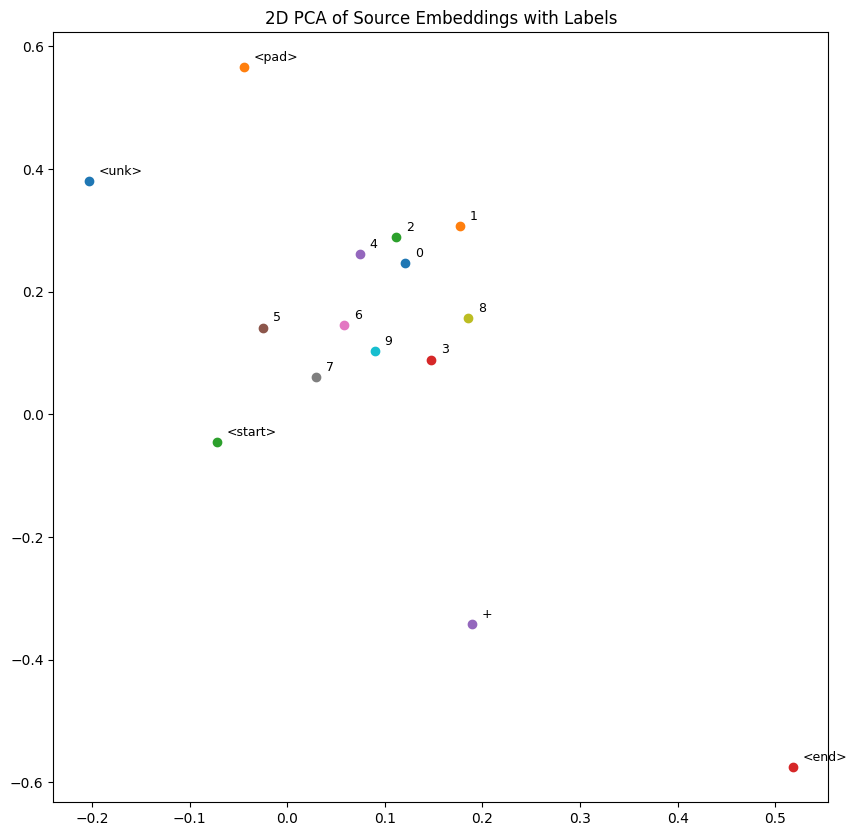

In [61]:
embedding_cpu = embedding_weight.cpu().detach()
print(embedding_cpu[: , :2])

# 逆辞書を作成してインデックスを文字に変換
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}

# 可視化
plt.figure(figsize=(10, 10))

# 各ポイントを散布図でプロットし、対応するラベルを表示
for i, (x, y) in enumerate(embedding_cpu[:, :2]):  # [:, :2]をスライスし、次にenumerate
    label = reverse_vocab_src[i]  # インデックスを元のトークンに戻す
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)  # 各点の近くにラベルを表示

plt.title("2D PCA of Source Embeddings with Labels")
plt.show()

## Attentionを確認

In [62]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: ++15+85
memory: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5971e+00, -8.2526e-01,  1.3346e+00, -1.1294e+00,  1.4418e+00,  4.0258e+00,  2.1590e+00,
           1.6075e-02,  1.2236e+00,  2.7904e-01,  2.0804e+00,  1.3226e-01,  1.4298e+00, -9.5698e-01,
           2.5354e+00, -2.2673e+00]],

        [[ 1.6649e+00, -1.7817e+00,  1.6147e+00, -1.2732e+00,  1.5407e+00,  4.0108e+00,  2.1906e+00,
           1.4575e-02,  1.2336e+00,  2.7889e-01,  2.0836e+00,  1.3225e-01,  1.4308e+00, -9.5698e-01,
           2.5358e+00, -2.2673e+00]],

        [[ 8.4889e-01,  2.3693e-01,  8.5299e-03, -3.8545e-01, -1.1706e+00,  6.5336e-01,  2.9901e+00,
           8.5998e-01, -1.3360e+00,  2.2236e+00,  5.6960e-01,  4.6267e+00, -1.8839e+00,  1.1955e+00,
          -2.2489e+00,  1.9996e+00]],

        [[-8.5

text: ++15+85
memory: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5971e+00, -8.2526e-01,  1.3346e+00, -1.1294e+00,  1.4418e+00,  4.0258e+00,  2.1590e+00,
           1.6075e-02,  1.2236e+00,  2.7904e-01,  2.0804e+00,  1.3226e-01,  1.4298e+00, -9.5698e-01,
           2.5354e+00, -2.2673e+00]],

        [[ 1.6649e+00, -1.7817e+00,  1.6147e+00, -1.2732e+00,  1.5407e+00,  4.0108e+00,  2.1906e+00,
           1.4575e-02,  1.2336e+00,  2.7889e-01,  2.0836e+00,  1.3225e-01,  1.4308e+00, -9.5698e-01,
           2.5358e+00, -2.2673e+00]],

        [[ 8.4889e-01,  2.3693e-01,  8.5299e-03, -3.8545e-01, -1.1706e+00,  6.5336e-01,  2.9901e+00,
           8.5998e-01, -1.3360e+00,  2.2236e+00,  5.6960e-01,  4.6267e+00, -1.8839e+00,  1.1955e+00,
          -2.2489e+00,  1.9996e+00]],

        [[-8.5

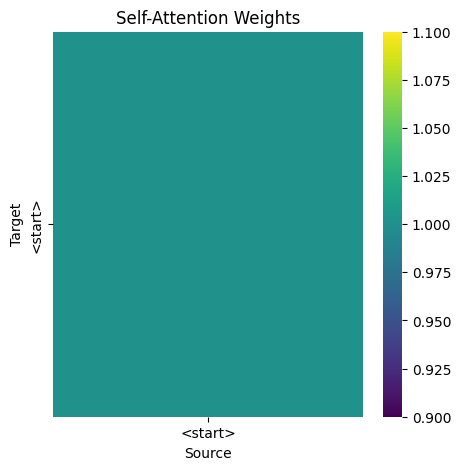

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 16])
multi_attention: 
[[5.6469145e-07 3.1860590e-02 3.2717202e-02 7.0333385e-01 2.2205144e-01
  1.6962270e-03 7.6274727e-03 6.8383676e-04 2.8769889e-05]]
After Attention: tensor([[[ 0.8125,  0.6016,  0.6161, -5.0947, -1.7959,  2.7782,  8.1734, -1.3654,  1.7030, -1.4989,
           1.8164,  4.8102, -5.9747,  1.4816, -5.2499, -1.0781]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


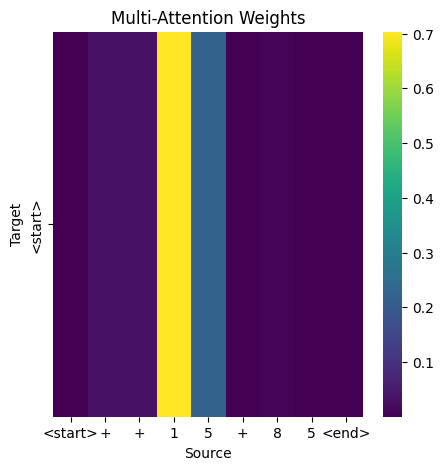

output.shape: torch.Size([1, 15])
output: tensor([[ 3.2975, 16.9984,  6.3792, -4.6191,  6.5788, -2.4251,  4.9118,  3.1230,  4.1009,  6.0436,
         -2.0420, -2.7779, -6.3180, -2.8343,  4.3210]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[12],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  4.6267, -1.8859,  1.1955, -2.2495,  1.9996]]], device='cuda:0')
now tgt: 1
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  

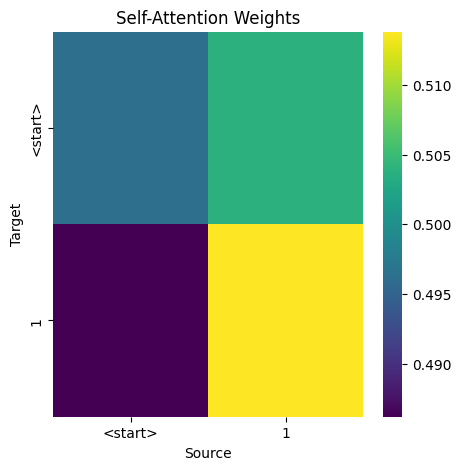

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 16])
multi_attention: 
[[1.3076922e-07 4.9877498e-02 4.9798481e-02 5.5225712e-01 2.3591030e-01
  1.1503748e-02 9.0091005e-02 9.2464127e-03 1.3153583e-03]
 [5.3284328e-09 5.7379170e-06 1.4989458e-05 2.4732091e-02 9.6020454e-01
  5.7133677e-04 1.3977123e-02 4.9422140e-04 6.0392735e-10]]
After Attention: tensor([[[ 0.3798, -0.2266,  0.4988, -2.1396, -3.6904,  4.9916,  7.7305, -0.3065,  1.1935, -3.4685,
           2.3598,  3.4305,  1.0371, -8.8967,  1.1652, -4.4867]],

        [[ 0.8826, -0.1386,  1.8811,  0.6596,  2.1847,  2.4017, -5.2736,  0.3421,  5.3193, -2.1613,
          -6.2814,  0.4744,  4.0418, -8.2239,  0.9407, -1.1140]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


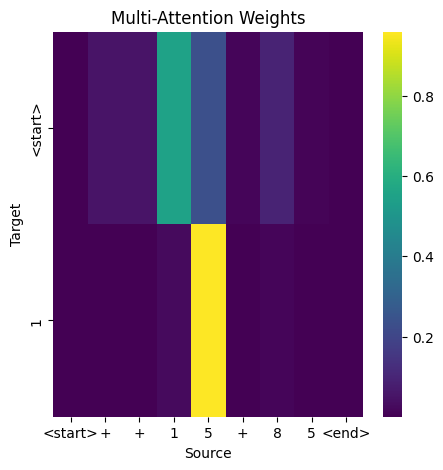

output.shape: torch.Size([1, 15])
output: tensor([[ -0.0904, -11.2787,  -0.4325,  -4.5549,  -1.3608,  12.0435,  -7.4741,  -0.0371,  -5.1452,
          -1.4353,  -4.2497,  -3.7132,  -4.5191,  -0.1928,   5.6282]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 2
ys: tensor([[12],
        [ 1],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  4.6267, -1.8859,  1.1955, -2.2495,  1.9996]],

        [[ 0.8111,  0.1497,  0.5191,  0.5436,  1.2639,  1.2612, -1.7843,  1.2259,  0.9597,  1.4489,
          -2.2744,  3.3834,  1.5872, -0.6565, -2.0340,  2.5939]]], device='cuda:0')
now tgt: 15
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  

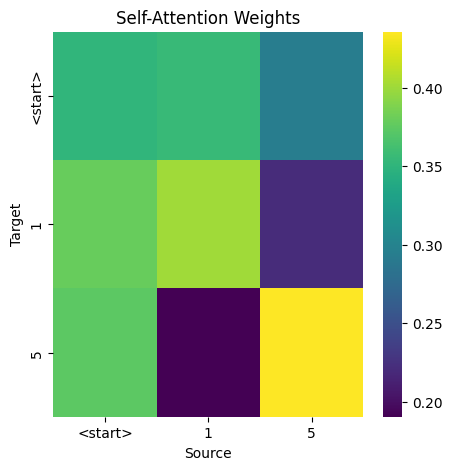

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 16])
multi_attention: 
[[1.46552270e-06 7.42699876e-02 7.32155517e-02 2.58243263e-01
  1.21246405e-01 2.95814965e-02 2.76393652e-01 9.85917598e-02
  6.84563890e-02]
 [3.65776600e-08 7.91350340e-06 2.18811638e-05 1.65508296e-02
  9.20767665e-01 1.83542236e-03 5.54314815e-02 5.38477814e-03
  1.37610643e-08]
 [4.93225173e-07 7.18961892e-05 7.04903287e-05 1.16604194e-01
  5.42527065e-02 5.42233232e-03 8.12452972e-01 1.11223981e-02
  2.43522913e-06]]
After Attention: tensor([[[ 0.6495,  0.0498, -0.4644, -1.5887, -1.6416,  4.3662,  3.4878, -0.4894, -1.4397, -6.6203,
           2.0984,  3.8120,  5.0717, -9.4375,  4.7217, -1.8215]],

        [[ 0.8666, -0.5296,  1.6327,  0.4825,  1.4776,  2.9298, -4.3059,  0.3743,  5.0739, -2.7088,
          -5.1129,  0.4586,  4.5607, -8.9955,  3.2782, -3.1400]],

        [[-0.2147, -0.7309,  0.

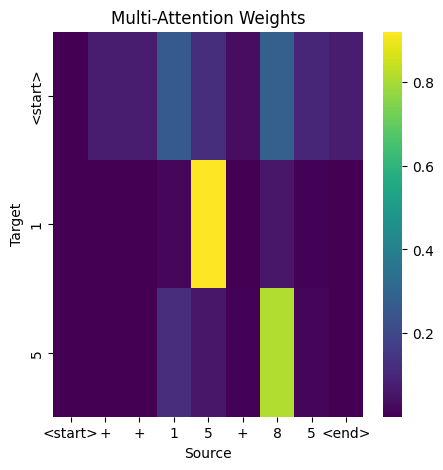

output.shape: torch.Size([1, 15])
output: tensor([[ -0.3471,  -3.0349,  -9.4565,  -1.2793,  -0.9313,  -2.0779, -13.7679,  -2.1234,  11.3432,
          -2.6205,  -6.7869,  -7.5081,  -2.9239,  -4.8188,   7.2294]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 8

------------------

iter: 3
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  4.6267, -1.8859,  1.1955, -2.2495,  1.9996]],

        [[ 0.8111,  0.1497,  0.5191,  0.5436,  1.2639,  1.2612, -1.7843,  1.2259,  0.9597,  1.4489,
          -2.2744,  3.3834,  1.5872, -0.6565, -2.0340,  2.5939]],

        [[ 0.8838, -0.3599,  0.5490, -0.5422, -0.4339, -1.2565,  1.8836,  1.8194, -1.7147, -0.1562,
         

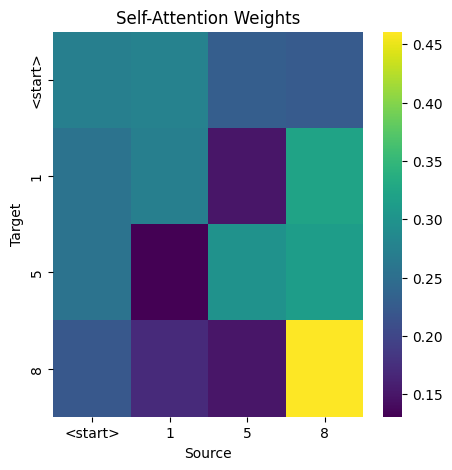

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 16])
multi_attention: 
[[3.9917795e-06 5.9407465e-02 6.6152222e-02 7.7239312e-02 2.6345914e-02
  1.6702620e-02 1.4023443e-01 1.3034515e-01 4.8356891e-01]
 [1.7601086e-06 7.9336358e-05 2.8153911e-04 2.0567730e-02 6.0691333e-01
  9.2363404e-03 2.2195300e-01 1.4095549e-01 1.1384666e-05]
 [1.2150534e-05 2.3053143e-04 2.8064946e-04 4.7857828e-02 1.3493257e-02
  7.7802176e-03 8.5341400e-01 7.6419502e-02 5.1180518e-04]
 [8.1442222e-06 4.4436139e-04 4.4045053e-04 6.2668798e-03 1.5696203e-02
  3.7166772e-03 1.1021024e-01 8.5990810e-01 3.3089204e-03]]
After Attention: tensor([[[ 1.1570,  0.5520, -0.7962, -2.0389, -0.3259,  5.4502,  1.5775, -0.4958, -2.6470, -6.2693,
           2.8691,  4.4635,  5.1511, -9.0530,  1.2153, -0.2602]],

        [[ 0.6722, -0.4958,  1.0997, -0.3258,  0.3851,  3.4911, -2.2858,  0.5953,  4.9655, -3.8574,


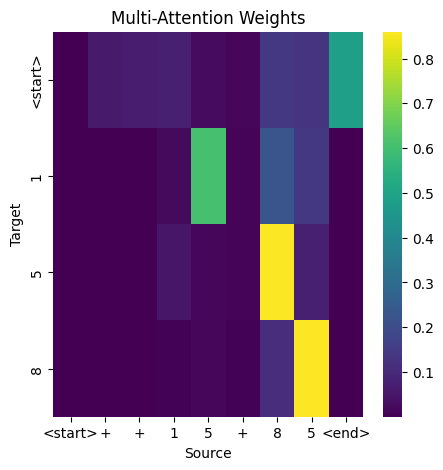

output.shape: torch.Size([1, 15])
output: tensor([[ -2.0515, -13.7787,  -3.8227,  -2.1380,  -1.5719,   9.3395, -10.3295,  -2.4954,  -1.6715,
          -3.0526,  -6.7587,  -7.8995,  -4.2940,  -6.9117,  10.2054]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 4
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4355e-01,  1.2639e+00,  1.2612e+00, -1.7843e+00,
           1

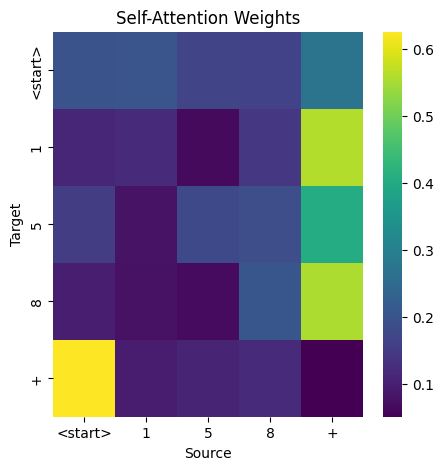

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 16])
multi_attention: 
[[8.1437427e-08 3.5766058e-02 3.6632981e-02 1.7526729e-03 1.1054223e-04
  1.8955251e-04 9.2976855e-04 2.4238159e-03 9.2219442e-01]
 [3.3261135e-02 1.7393583e-02 3.8520768e-02 9.7550556e-02 2.7329758e-01
  6.2954337e-03 9.7955093e-02 4.2575023e-01 9.9756112e-03]
 [4.6472107e-03 9.4380639e-03 9.2050796e-03 1.5984365e-01 5.5218181e-03
  4.7657052e-03 6.2140518e-01 1.4740761e-01 3.7765685e-02]
 [4.3395348e-03 1.6294904e-02 1.0629549e-02 5.2614566e-03 1.9197004e-03
  4.0652999e-04 9.9589229e-03 7.7244204e-01 1.7874731e-01]
 [1.2379314e-04 1.6790423e-06 8.1109988e-07 9.3359113e-06 2.8367219e-06
  3.5917827e-07 2.8936591e-02 8.8974082e-01 8.1183784e-02]]
After Attention: tensor([[[ 1.3174,  0.6918, -0.9497, -2.3220, -0.1542,  5.3697,  1.4547, -0.4807, -3.1620, -5.9849,
           3.1806,  5.1395,  4.8995,

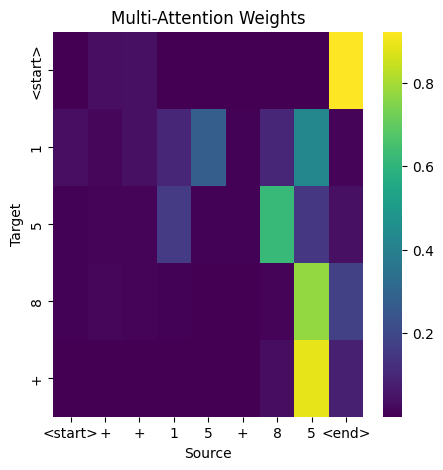

output.shape: torch.Size([1, 15])
output: tensor([[ 3.6733e-03, -8.8399e+00,  1.0020e+00, -1.6592e+00,  6.7108e-01,  1.1149e+01, -3.3209e+00,
          1.1905e+00, -3.9807e+00,  4.6942e-02, -7.7105e+00, -7.5341e+00, -6.2416e+00, -1.1000e+01,
          1.0945e+01]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4

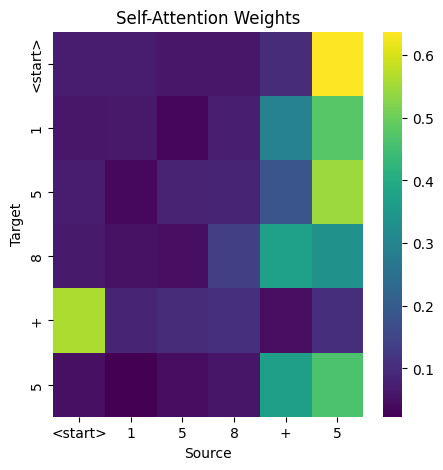

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 16])
multi_attention: 
[[2.61713967e-06 3.29552265e-03 1.07126404e-02 3.03028175e-03
  4.83322103e-04 4.63113887e-04 1.42114260e-03 5.86739555e-03
  9.74723876e-01]
 [2.33738660e-03 6.81239762e-04 6.89462386e-03 5.06105050e-02
  5.18158138e-01 6.83806650e-03 5.85073866e-02 3.53354514e-01
  2.61816103e-03]
 [1.43005501e-03 3.78047233e-04 1.79017743e-03 1.63619250e-01
  1.02206459e-02 8.82287137e-03 6.25740945e-01 1.49442047e-01
  3.85560207e-02]
 [3.38819955e-04 1.21777540e-03 2.05077417e-03 2.24301685e-03
  1.56459725e-03 3.13504890e-04 5.34386188e-03 8.83394599e-01
  1.03533074e-01]
 [1.95559207e-03 1.50759229e-06 1.44745820e-06 9.23607331e-06
  4.13322005e-06 1.49764151e-06 1.31719960e-02 6.15347028e-01
  3.69507462e-01]
 [6.59100071e-04 5.16808173e-03 5.72996661e-02 3.98556024e-01
  1.88253564e-03 1.19870377e-03 3.454

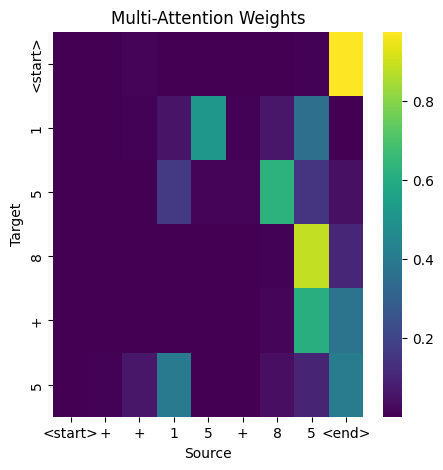

output.shape: torch.Size([1, 15])
output: tensor([[  4.4045,   5.1447,   4.5652,   2.2401,   4.8263,   4.5570,   3.3280,   4.2062,   3.7308,
           3.7640, -11.6280, -10.8860, -12.1780, -18.7681,  16.2287]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 6
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14],
        [ 5],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4355e-01,  1.2639e+00,  1.2612e+0

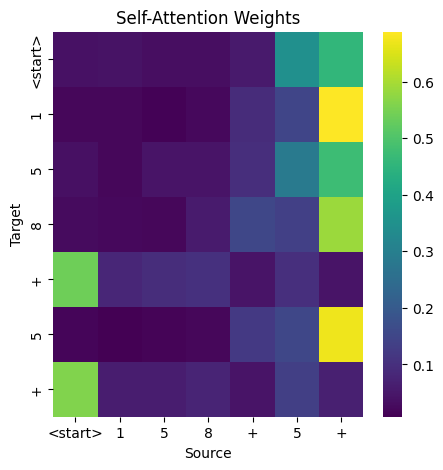

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 16])
multi_attention: 
[[3.5297469e-06 4.1288831e-03 1.1152250e-02 1.8328632e-03 7.7243771e-05
  1.9847965e-05 2.1779700e-04 4.9734185e-04 9.8207021e-01]
 [2.9734266e-01 2.1350366e-04 4.6798596e-04 6.2813230e-02 4.7145700e-01
  1.3318521e-03 8.8758074e-02 7.7562526e-02 5.3157175e-05]
 [2.4073251e-01 1.2892796e-04 2.1340749e-04 1.7322305e-01 2.5745003e-02
  1.3384810e-03 5.1507169e-01 4.3167572e-02 3.7933755e-04]
 [3.1764475e-01 5.2096089e-04 4.1473491e-04 3.2229159e-02 5.8694690e-02
  5.6860776e-04 7.4118398e-02 5.1498705e-01 8.2155305e-04]
 [9.8387320e-03 6.2643358e-07 5.6052232e-07 4.0882583e-06 1.9047483e-06
  6.6083470e-07 9.9000996e-03 5.9175926e-01 3.8849404e-01]
 [2.5455695e-01 1.2415635e-03 2.4555393e-03 4.2765576e-01 4.7495876e-02
  1.3169992e-03 1.8182409e-01 8.1876144e-02 1.5770762e-03]
 [8.3234705e-02 6.76584

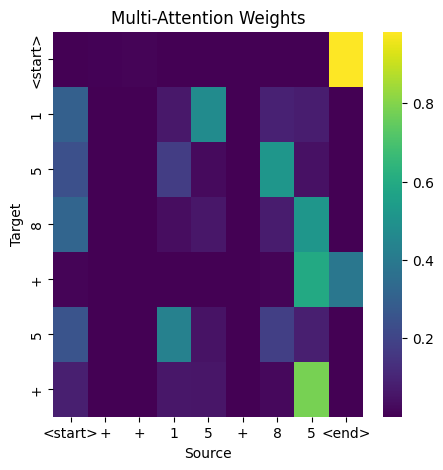

output.shape: torch.Size([1, 15])
output: tensor([[ -5.2364, -12.6524,  -3.2062,  -6.2723,  -4.0075,   4.8096,  -9.1331,  -5.5321,  -7.7855,
          -4.6556,  -9.0234,  -5.9200,  -7.2712,   4.1815,  15.1708]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 7
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14],
        [ 5],
        [14],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4355e-01,  1.2639e+

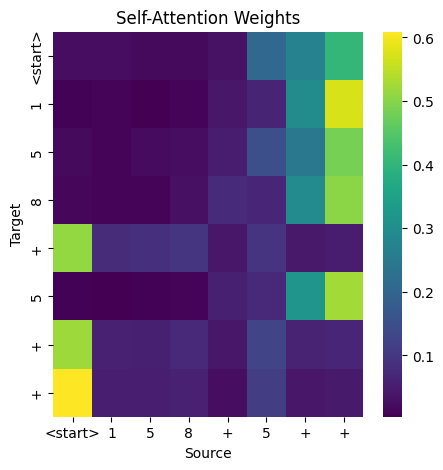

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 16])
multi_attention: 
[[7.7575110e-03 9.5163416e-03 7.3321089e-03 1.2677213e-02 1.6260043e-03
  1.5538535e-04 2.1623235e-02 2.0024085e-02 9.1928810e-01]
 [6.4828014e-01 2.4987943e-05 2.9835746e-05 1.2378090e-02 1.7546827e-01
  4.5564165e-04 1.0336149e-01 5.9993979e-02 7.4763843e-06]
 [6.6533810e-01 1.8311930e-05 1.2711186e-05 1.9207632e-02 9.4606318e-03
  3.0852680e-04 2.8152302e-01 2.4095511e-02 3.5556001e-05]
 [6.7110115e-01 2.8591348e-05 1.2045084e-05 4.5194663e-03 1.9366635e-02
  1.4304866e-04 7.4231617e-02 2.3055422e-01 4.3283984e-05]
 [6.6912569e-02 3.0374071e-07 2.2501854e-07 2.3067664e-06 1.3846482e-06
  4.7509030e-07 1.0428694e-02 6.2476915e-01 2.9788494e-01]
 [5.4864967e-01 1.8172202e-04 2.0338173e-04 1.0189406e-01 2.5629457e-02
  6.1079464e-04 2.4640335e-01 7.6172754e-02 2.5480220e-04]
 [6.3821638e-01 1.36404

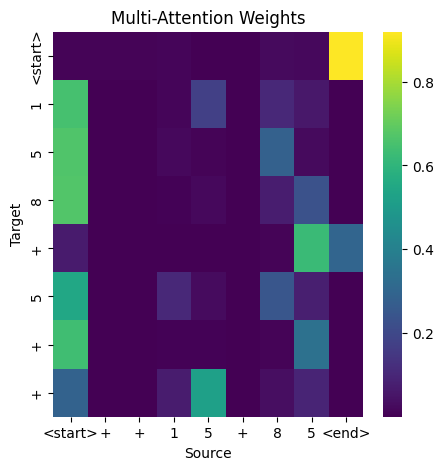

output.shape: torch.Size([1, 15])
output: tensor([[ -8.9141, -15.5879,  -8.7952,  -7.2806, -10.5784,  -4.1147, -13.1084, -10.2171,  -9.2522,
          -9.2543,  -8.4250,  -4.5901,  -2.7336,  22.4450,  14.8776]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 13

------------------

Input: ++15+85
Decoded sequence: 158+5++


In [63]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Multi-Attention Weights")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

tensor([[ 0.1207,  0.2468],
        [ 0.1769,  0.3067],
        [ 0.1118,  0.2888],
        [ 0.1474,  0.0893],
        [ 0.0744,  0.2606],
        [-0.0245,  0.1415],
        [ 0.0586,  0.1452],
        [ 0.0299,  0.0600],
        [ 0.1857,  0.1575],
        [ 0.0897,  0.1036],
        [-0.2035,  0.3810],
        [-0.0448,  0.5658],
        [-0.0723, -0.0455],
        [ 0.5183, -0.5755],
        [ 0.1889, -0.3414]])


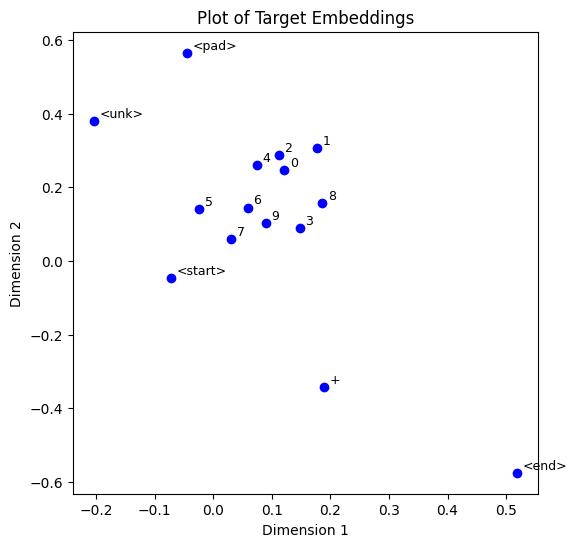

In [64]:
import numpy as np
embedding_cpu_01dim = embedding_weight.cpu().detach()[: , :2]
print(embedding_cpu_01dim)

reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

def plot_embedding_tgt_2d(ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))

    # 事前Embedding
    for i, (x, y) in enumerate(embedding_cpu_01dim):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9) 

    if tgt_embed is not None:
        tgt_embed = tgt_embed.detach().cpu().numpy()
        print(tgt_embed)
        print(tgt_embed.shape)
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=1)
        tgt_embed_2d = tgt_embed[:, :2]
        print(tgt_embed_2d)
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + f"({i})"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, str(i)+label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


plot_embedding_tgt_2d()

text: ++15+85
memory: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5971e+00, -8.2526e-01,  1.3346e+00, -1.1294e+00,  1.4418e+00,  4.0258e+00,  2.1590e+00,
           1.6075e-02,  1.2236e+00,  2.7904e-01,  2.0804e+00,  1.3226e-01,  1.4298e+00, -9.5698e-01,
           2.5354e+00, -2.2673e+00]],

        [[ 1.6649e+00, -1.7817e+00,  1.6147e+00, -1.2732e+00,  1.5407e+00,  4.0108e+00,  2.1906e+00,
           1.4575e-02,  1.2336e+00,  2.7889e-01,  2.0836e+00,  1.3225e-01,  1.4308e+00, -9.5698e-01,
           2.5358e+00, -2.2673e+00]],

        [[ 8.4889e-01,  2.3693e-01,  8.5299e-03, -3.8545e-01, -1.1706e+00,  6.5336e-01,  2.9901e+00,
           8.5998e-01, -1.3360e+00,  2.2236e+00,  5.6960e-01,  4.6267e+00, -1.8839e+00,  1.1955e+00,
          -2.2489e+00,  1.9996e+00]],

        [[-8.5

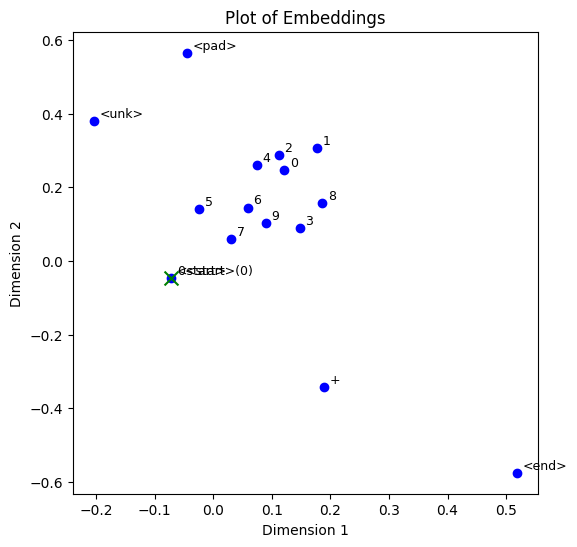

[[[-0.28924587  0.8178704  -1.2086385   3.1065784  -0.5898561
   -0.4980849   0.47985086  3.4004815   1.1798354   3.2258348
    0.21742761  0.5657737   2.2401133   3.1060188  -0.6853873
    2.211258  ]]]
(1, 1, 16)
[[-0.28924587  0.8178704 ]]


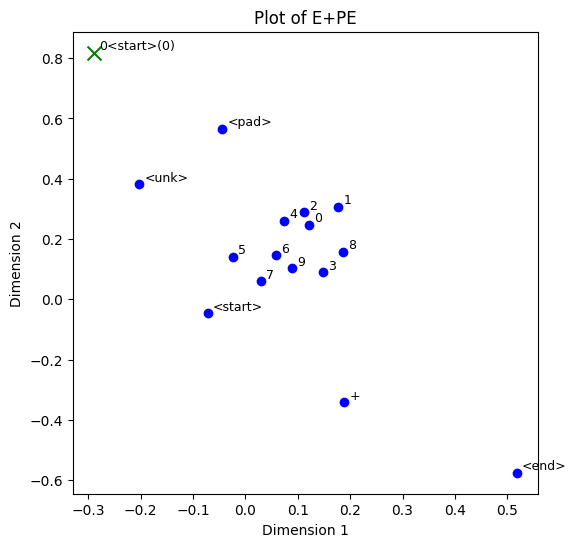

SelfAttention Layer
QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 1, 16])
WV.shape: torch.Size([1, 1, 16])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 16])
[[[-1.5466403   1.904439   -2.417085    1.8533584  -3.0309663
   -7.246384   -4.9945216  -1.6424036  -3.845997    0.33464316
   -5.1918683   2.584437   -4.48214     3.0924037  -8.409585
    4.818444  ]]]
(1, 1, 16)
[[-1.5466403  1.904439 ]]


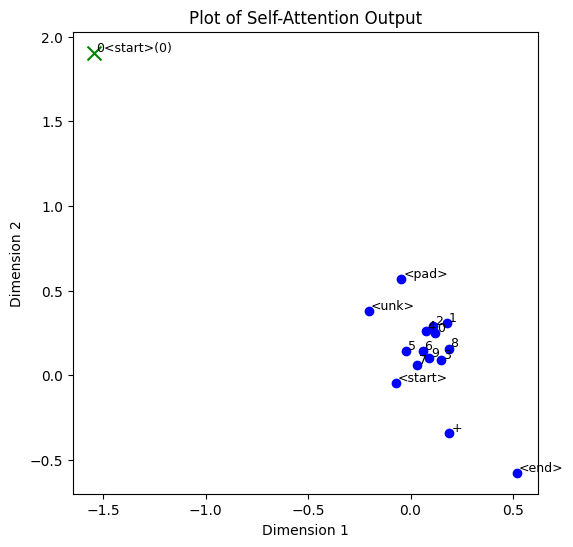

[[[-0.40565404  1.1559122  -0.7364564   1.4051535  -0.9176121
   -1.5787117  -0.51936615  0.4336653  -0.5691265   0.89021057
   -0.7070026   0.9422947  -0.25460306  3.1256394  -1.9620726
    3.6005418 ]]]
(1, 1, 16)
[[-0.40565404  1.1559122 ]]


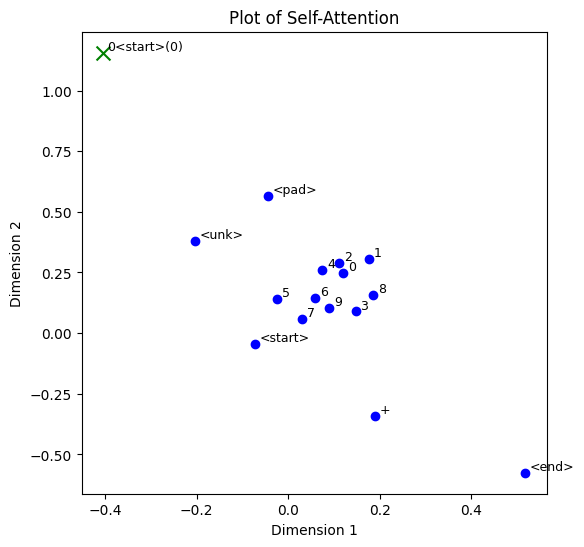

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 16])
After Attention: tensor([[[ 0.8125,  0.6016,  0.6161, -5.0947, -1.7959,  2.7782,  8.1734, -1.3654,  1.7030, -1.4989,
           1.8164,  4.8102, -5.9747,  1.4816, -5.2499, -1.0781]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 1.0814763  -0.28286734  1.1984526  -3.4058719  -0.2719659
    2.8764293   3.8143003  -1.2623794   1.5201906  -0.9268921
    1.3628528   1.8047636  -1.9303184  -2.0004969  -0.17663333
   -3.4214528 ]]]
(1, 1, 16)
[[ 1.0814763  -0.28286734]]


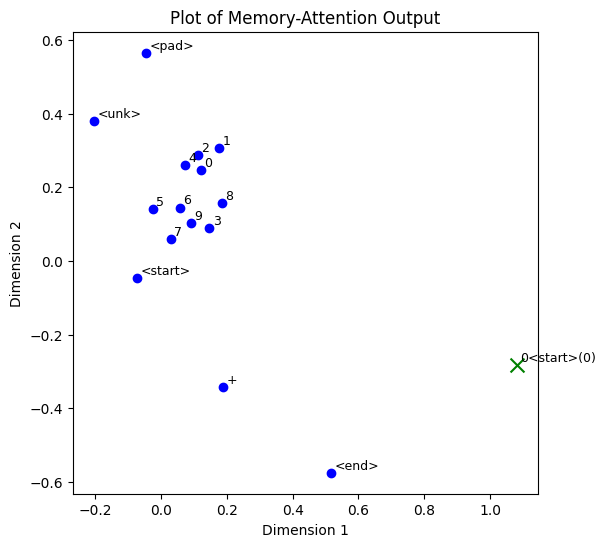

[[[ 0.81246233  0.60163885  0.6161103  -5.094701   -1.7958963
    2.7781692   8.17343    -1.3654004   1.7029991  -1.4989241
    1.8164331   4.8101645  -5.9746747   1.4815505  -5.249899
   -1.0781431 ]]]
(1, 1, 16)
[[0.81246233 0.60163885]]


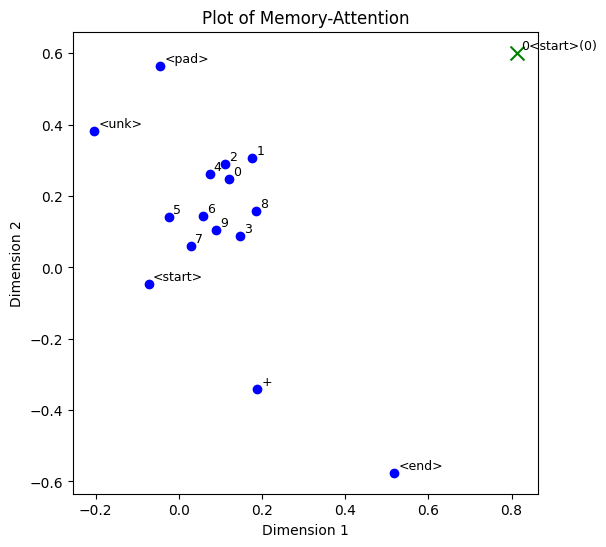

output.shape: torch.Size([1, 15])
output: tensor([[ 3.2975, 16.9984,  6.3792, -4.6191,  6.5788, -2.4251,  4.9118,  3.1230,  4.1009,  6.0436,
         -2.0420, -2.7779, -6.3180, -2.8343,  4.3210]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[12],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  4.6267, -1.8859,  1.1955, -2.2495,  1.9996]]], device='cuda:0')
now tgt: 1
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  

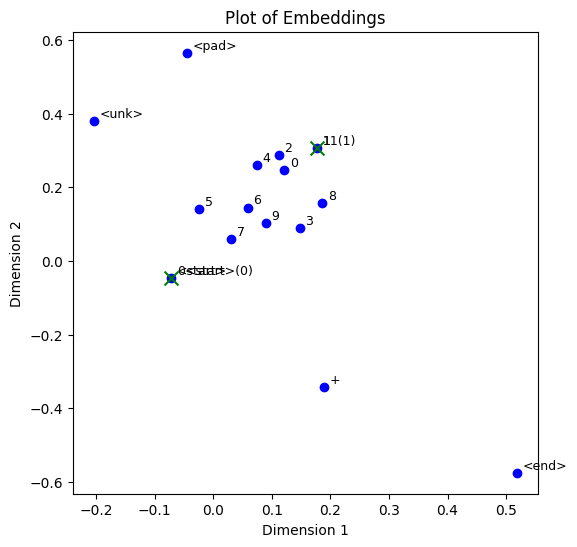

[[[-0.28924587  0.8178704  -1.2086385   3.1065784  -0.5898561
   -0.4980849   0.47985086  3.4004815   1.1798354   3.2258348
    0.21742761  0.5657737   2.2401133   3.1060188  -0.6853873
    2.211258  ]]

 [[ 1.5492418   1.7672291  -0.4931354  -0.01779264 -1.3663338
    0.69302917  2.9270303   0.8639731  -1.3560205   2.2240398
    0.56327564  4.6267147  -1.8858978   1.1955233  -2.2495263
    1.9995832 ]]]
(2, 1, 16)
[[-0.28924587  0.8178704 ]
 [ 1.5492418   1.7672291 ]]


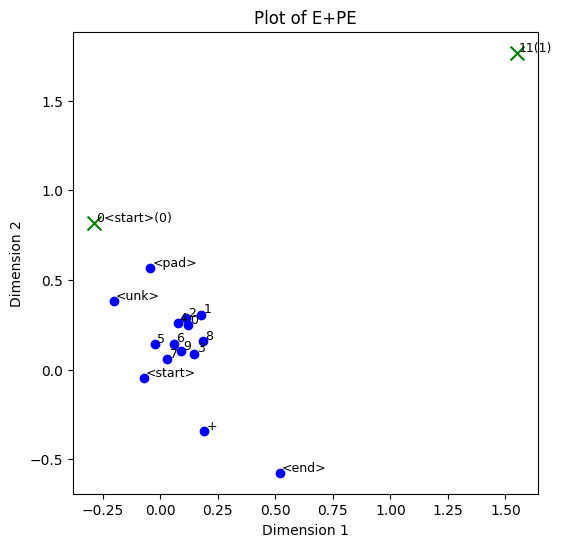

SelfAttention Layer
QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 2, 16])
WV.shape: torch.Size([1, 2, 16])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 16])
[[[-1.4574549  -0.2645269  -0.71763587  2.883855   -3.682732
   -2.5004022  -2.299293    0.68451595 -2.1788611  -0.7074811
   -1.5588796  -2.3240907   1.0768555  -3.517301   -0.38404042
   -0.3604874 ]]

 [[-1.4556882  -0.30749285 -0.68397063  2.9042685  -3.6956432
   -2.4063866  -2.2459016   0.730611   -2.1458359  -0.7281248
   -1.4869119  -2.4213264   1.1869763  -3.6482358  -0.22505859
   -0.46307948]]]
(2, 1, 16)
[[-1.4574549  -0.2645269 ]
 [-1.4556882  -0.30749285]]


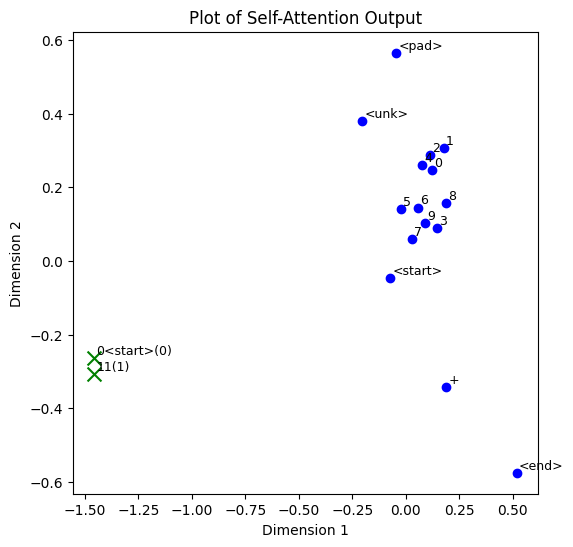

[[[-1.0510648   0.19047068 -0.88760155  2.6798027  -1.9985659
   -1.0438418  -0.45405045  1.4615254  -0.51417774  0.9277708
   -0.36980247 -0.6052116   1.2730873  -0.23448367 -0.3129261
    1.506565  ]]

 [[ 0.3274517   1.4054315  -0.33948624  1.7986476  -2.6442728
   -0.33393407  0.12414805  0.8406583  -1.7677549   0.8656187
   -0.16583295  1.3520763  -0.07850218 -1.9269015  -0.9993997
    1.9465569 ]]]
(2, 1, 16)
[[-1.0510648   0.19047068]
 [ 0.3274517   1.4054315 ]]


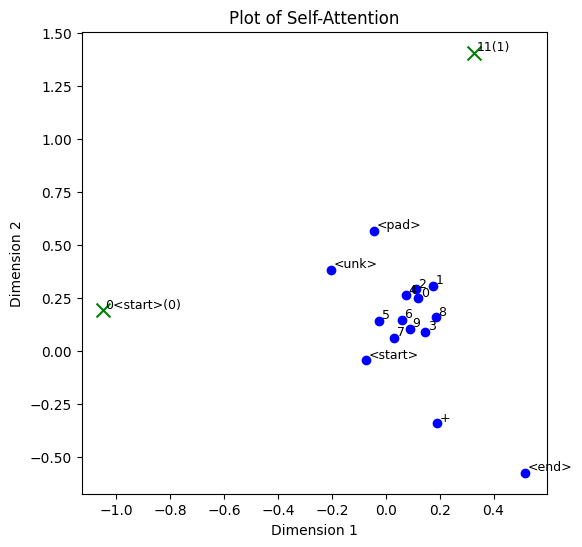

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 16])
After Attention: tensor([[[ 0.3798, -0.2266,  0.4988, -2.1396, -3.6904,  4.9916,  7.7305, -0.3065,  1.1935, -3.4685,
           2.3598,  3.4305,  1.0371, -8.8967,  1.1652, -4.4867]],

        [[ 0.8826, -0.1386,  1.8811,  0.6596,  2.1847,  2.4017, -5.2736,  0.3421,  5.3193, -2.1613,
          -6.2814,  0.4744,  4.0418, -8.2239,  0.9407, -1.1140]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 1.3475969e+00  8.2972221e-02  1.1629722e+00 -3.1004646e+00
    1.3711914e-01  3.0470433e+00  3.1191516e+00 -1.2611930e+00
    1.0720445e+00 -1.6628385e+00  1.0707381e+00  2.3756509e+00
   -7.1991074e-01 -2.7855408e+00  5.8552557e-01 -2.5211625e+00]]

 [[ 9.0026891e-01 -6.3525462e-01  2.5906236e+00 -3.8234293e-03
    3.7540886e+00  2.1855803e+00 -3.8251219e+00  7.9083997e-01
    6.1476898e+00 -1.2132169e+00 -3

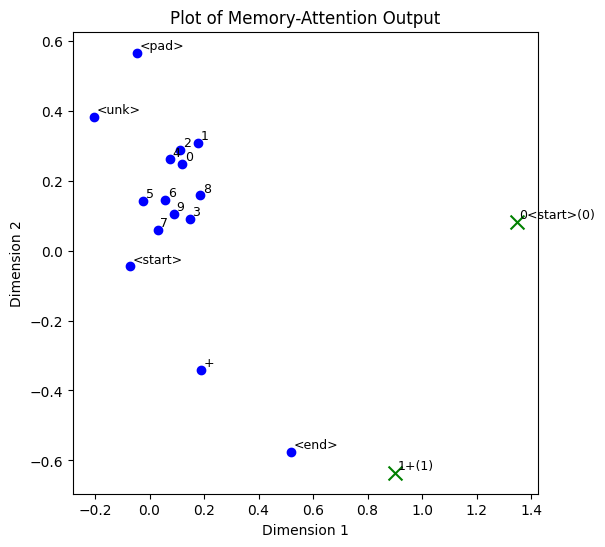

[[[ 0.37981868 -0.22664118  0.4988048  -2.1395667  -3.69045
    4.991558    7.7304845  -0.3065071   1.1935366  -3.4685156
    2.3598123   3.4304845   1.0371     -8.896691    1.165244
   -4.486711  ]]

 [[ 0.8826104  -0.13860041  1.8811177   0.65957296  2.184708
    2.4016676  -5.27358     0.34207729  5.319346   -2.1613104
   -6.2814145   0.4744243   4.041809   -8.223913    0.94069856
   -1.11399   ]]]
(2, 1, 16)
[[ 0.37981868 -0.22664118]
 [ 0.8826104  -0.13860041]]


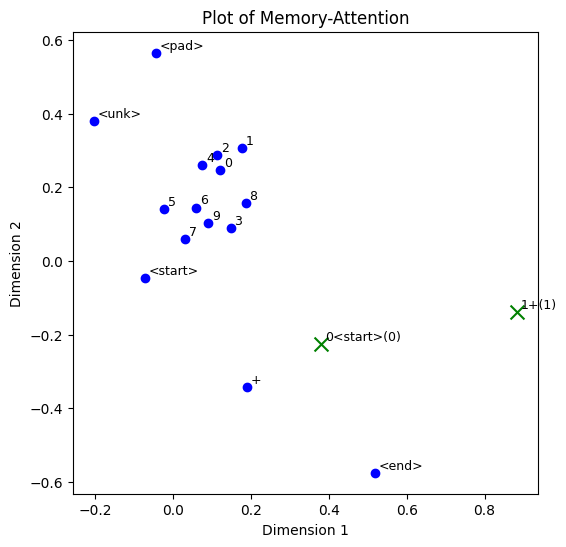

output.shape: torch.Size([1, 15])
output: tensor([[ -0.0904, -11.2787,  -0.4325,  -4.5549,  -1.3608,  12.0435,  -7.4741,  -0.0371,  -5.1452,
          -1.4353,  -4.2497,  -3.7132,  -4.5191,  -0.1928,   5.6282]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 2
ys: tensor([[12],
        [ 1],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  4.6267, -1.8859,  1.1955, -2.2495,  1.9996]],

        [[ 0.8111,  0.1497,  0.5191,  0.5436,  1.2639,  1.2612, -1.7843,  1.2259,  0.9597,  1.4489,
          -2.2744,  3.3834,  1.5872, -0.6565, -2.0340,  2.5939]]], device='cuda:0')
now tgt: 15
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  

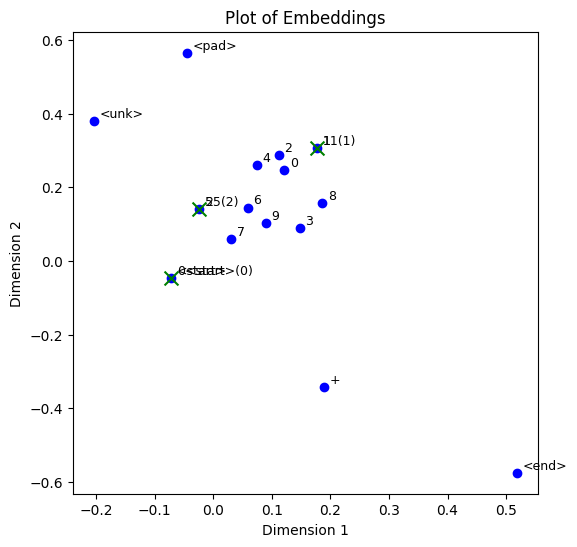

[[[-0.28924587  0.8178704  -1.2086385   3.1065784  -0.5898561
   -0.4980849   0.47985086  3.4004815   1.1798354   3.2258348
    0.21742761  0.5657737   2.2401133   3.1060188  -0.6853873
    2.211258  ]]

 [[ 1.5492418   1.7672291  -0.4931354  -0.01779264 -1.3663338
    0.69302917  2.9270303   0.8639731  -1.3560205   2.2240398
    0.56327564  4.6267147  -1.8858978   1.1955233  -2.2495263
    1.9995832 ]]

 [[ 0.8111002   0.14967456  0.5191473   0.54355025  1.2638816
    1.2611748  -1.784307    1.2258816   0.9596635   1.4488797
   -2.2743957   3.3834002   1.5871867  -0.65645987 -2.0339627
    2.59393   ]]]
(3, 1, 16)
[[-0.28924587  0.8178704 ]
 [ 1.5492418   1.7672291 ]
 [ 0.8111002   0.14967456]]


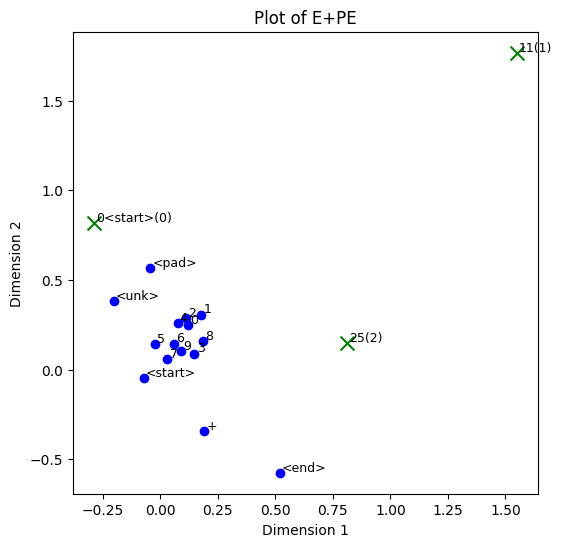

SelfAttention Layer
QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 3, 16])
WV.shape: torch.Size([1, 3, 16])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 16])
[[[-1.2283208  -0.83842754 -0.66520315  2.4918303  -4.0476575
   -0.7792927  -0.8948567   1.0123227  -1.4012015  -1.4642289
    0.19771104 -2.5714524   2.3975217  -4.22549     3.0079045
   -1.989149  ]]

 [[-1.2838106  -0.7294865  -0.65197545  2.6050355  -3.967154
   -1.1331588  -1.2017956   0.9668964  -1.5684602  -1.2925094
   -0.18214595 -2.585853    2.1555917  -4.1517887   2.290007
   -1.6649117 ]]

 [[-1.1338263  -0.71207404 -0.95687467  2.1094065  -4.1030426
   -0.8300691  -0.7165751   0.737134   -1.335089   -1.6368198
    0.37181836 -1.77554     2.0008183  -3.3356662   3.1555884
   -1.8127476 ]]]
(3, 1, 16)
[[-1.2283208  -0.83842754]
 [-1.2838106  -0.7294865 ]
 [-1.1338263  -0.71207404]]


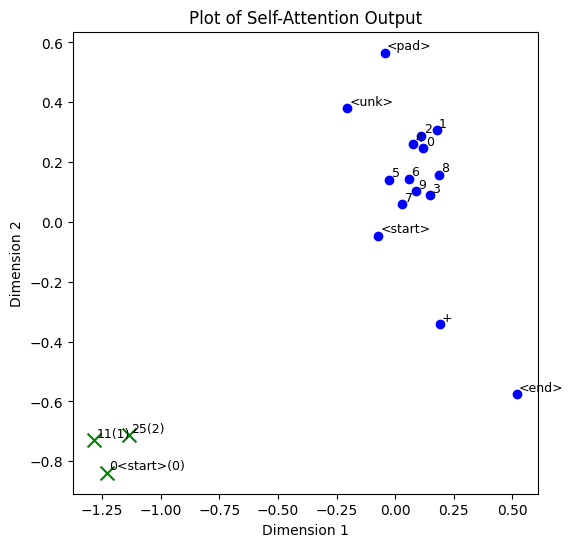

[[[-1.1741539  -0.49545634 -1.1190503   2.374313   -2.3605013
   -0.3585993  -0.2711483   1.4706073  -0.35386065  0.55830365
    0.0506621  -0.879139    1.6445583  -1.1203073   1.0421308
   -0.17729591]]

 [[ 0.2560434   0.84952295 -0.5856429   1.5684451  -3.125886
    0.2974757   0.32546535  0.8771452  -1.7220296   0.5428593
    0.23490301  1.2007121   0.23808967 -2.8950644   0.23706779
    0.43136036]]

 [[-0.23144244 -0.68088096 -0.05793399  1.6411589  -1.8052119
    0.9072249  -0.73503196  0.96138215 -0.26832774  0.03931847
   -0.7346291   0.9863172   1.8833002  -4.1112547   0.8844836
    0.9256645 ]]]
(3, 1, 16)
[[-1.1741539  -0.49545634]
 [ 0.2560434   0.84952295]
 [-0.23144244 -0.68088096]]


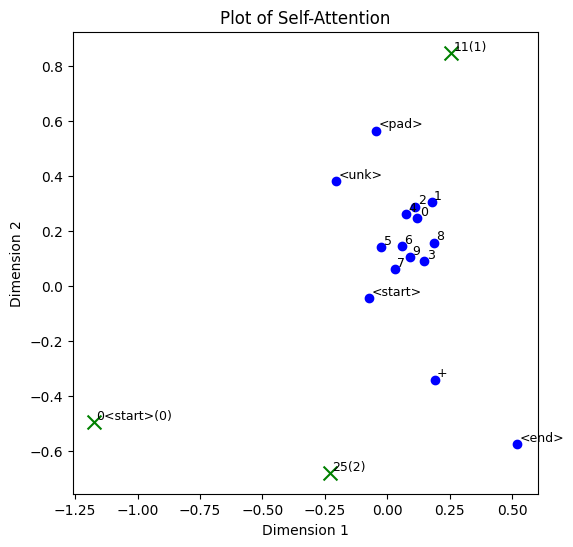

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 16])
After Attention: tensor([[[ 0.6495,  0.0498, -0.4644, -1.5887, -1.6416,  4.3662,  3.4878, -0.4894, -1.4397, -6.6203,
           2.0984,  3.8120,  5.0717, -9.4375,  4.7217, -1.8215]],

        [[ 0.8666, -0.5296,  1.6327,  0.4825,  1.4776,  2.9298, -4.3059,  0.3743,  5.0739, -2.7088,
          -5.1129,  0.4586,  4.5607, -8.9955,  3.2782, -3.1400]],

        [[-0.2147, -0.7309,  0.4537, -0.1319, -2.1005, -4.5267,  5.3856, -0.3769,  0.2912, -7.5557,
          -1.4074,  1.7820,  4.5889, -4.8943,  8.7460,  2.3211]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 1.9293226e+00  1.2012055e+00  4.6379194e-01 -2.7211144e+00
    4.3364272e-01  3.4620993e+00  2.1822481e+00 -1.4676280e+00
   -7.4639273e-01 -3.8202198e+00  1.0075142e+00  4.3232560e+00
    1.9323742e+00 -4.7754855e+00  1.6082470e+00 -1.3247332e-

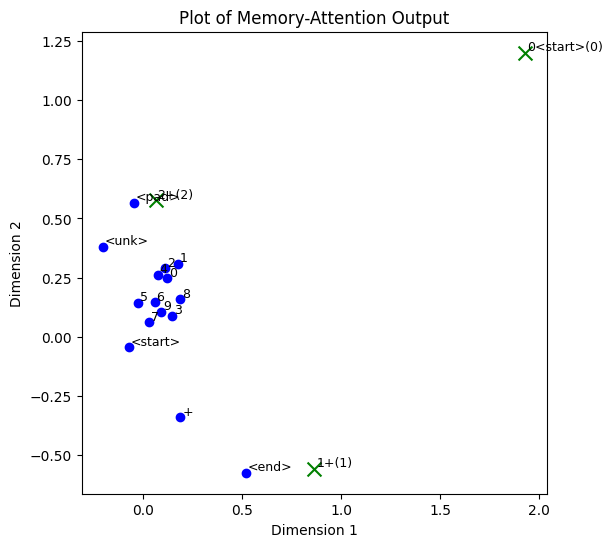

[[[ 0.6494817   0.04976025 -0.46443883 -1.5887194  -1.6416395
    4.3662467   3.4878323  -0.4893614  -1.4397295  -6.620332
    2.0984054   3.811961    5.0716863  -9.43753     4.72169
   -1.8214962 ]]

 [[ 0.86657685 -0.52959263  1.632713    0.48245585  1.4776098
    2.9298337  -4.305898    0.37427765  5.0738597  -2.708833
   -5.112874    0.45860428  4.560679   -8.995483    3.2781622
   -3.1400187 ]]

 [[-0.21471736 -0.73086756  0.45373392 -0.13185859 -2.100521
   -4.5267096   5.3855524  -0.37686384  0.2912006  -7.555667
   -1.4074312   1.7819867   4.5889196  -4.8943467   8.745984
    2.3211064 ]]]
(3, 1, 16)
[[ 0.6494817   0.04976025]
 [ 0.86657685 -0.52959263]
 [-0.21471736 -0.73086756]]


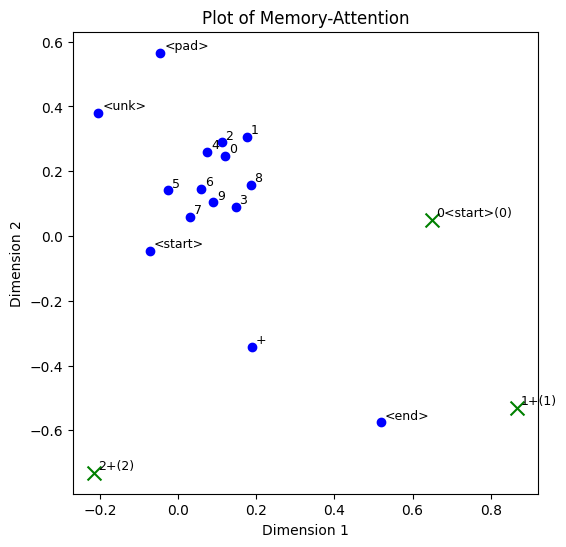

output.shape: torch.Size([1, 15])
output: tensor([[ -0.3471,  -3.0349,  -9.4565,  -1.2793,  -0.9313,  -2.0779, -13.7679,  -2.1234,  11.3432,
          -2.6205,  -6.7869,  -7.5081,  -2.9239,  -4.8188,   7.2294]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 8

------------------

iter: 3
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[-0.2892,  0.8179, -1.2086,  3.1066, -0.5899, -0.4981,  0.4799,  3.4005,  1.1798,  3.2258,
           0.2174,  0.5658,  2.2401,  3.1060, -0.6854,  2.2113]],

        [[ 1.5492,  1.7672, -0.4931, -0.0178, -1.3663,  0.6930,  2.9270,  0.8640, -1.3560,  2.2240,
           0.5633,  4.6267, -1.8859,  1.1955, -2.2495,  1.9996]],

        [[ 0.8111,  0.1497,  0.5191,  0.5436,  1.2639,  1.2612, -1.7843,  1.2259,  0.9597,  1.4489,
          -2.2744,  3.3834,  1.5872, -0.6565, -2.0340,  2.5939]],

        [[ 0.8838, -0.3599,  0.5490, -0.5422, -0.4339, -1.2565,  1.8836,  1.8194, -1.7147, -0.1562,
         

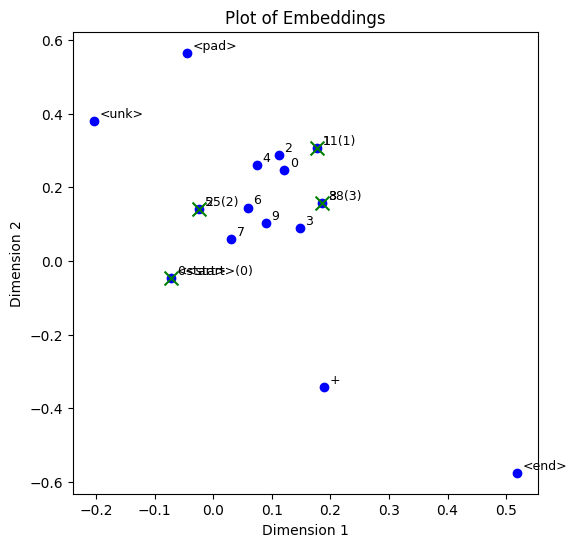

[[[-0.28924587  0.8178704  -1.2086385   3.1065784  -0.5898561
   -0.4980849   0.47985086  3.4004815   1.1798354   3.2258348
    0.21742761  0.5657737   2.2401133   3.1060188  -0.6853873
    2.211258  ]]

 [[ 1.5492418   1.7672291  -0.4931354  -0.01779264 -1.3663338
    0.69302917  2.9270303   0.8639731  -1.3560205   2.2240398
    0.56327564  4.6267147  -1.8858978   1.1955233  -2.2495263
    1.9995832 ]]

 [[ 0.8111002   0.14967456  0.5191473   0.54355025  1.2638816
    1.2611748  -1.784307    1.2258816   0.9596635   1.4488797
   -2.2743957   3.3834002   1.5871867  -0.65645987 -2.0339627
    2.59393   ]]

 [[ 0.88381207 -0.3598848   0.5490281  -0.54224956 -0.4338538
   -1.2565482   1.883607    1.8194342  -1.7147171  -0.15622085
   -0.23370215  3.5962753   0.76969075  1.2749015   0.7797096
    2.2574174 ]]]
(4, 1, 16)
[[-0.28924587  0.8178704 ]
 [ 1.5492418   1.7672291 ]
 [ 0.8111002   0.14967456]
 [ 0.88381207 -0.3598848 ]]


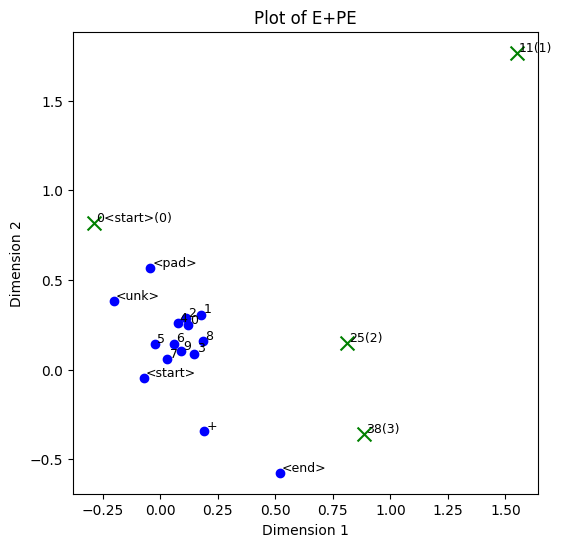

SelfAttention Layer
QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 4, 16])
WV.shape: torch.Size([1, 4, 16])
attn_weight.shape: torch.Size([1, 4, 4])
AV.shape: torch.Size([1, 4, 16])
[[[-1.1629411  -1.0464609  -0.5235808   1.8456852  -3.7864685
    0.6238279  -0.3507324   1.8537147  -0.40055624 -1.0954223
    0.787196   -3.4440918   3.0618575  -4.1536555   3.3313422
   -2.9854665 ]]

 [[-1.1722898  -1.0625659  -0.4533592   1.6429855  -3.6189146
    0.990735   -0.32352296  2.186817   -0.08118738 -0.81947356
    0.7845799  -3.8312755   3.1851392  -4.072612    2.9844444
   -3.1965208 ]]

 [[-1.072334   -1.0414176  -0.6682882   1.329048   -3.7218685
    1.140363   -0.01442484  1.9953347   0.0381057  -1.0690448
    1.1384623  -3.2402804   3.0504212  -3.5141594   3.5599017
   -3.2558327 ]]

 [[-1.1056803  -1.1343688  -0.4655282   1.1247925  -3.4674268
    1.7977118   0.03813282  2.6054494   0.5397974  -0.6314804
    1.1642222  -4.0956454   3.4292436  -3.7110271   3.1509695
   -3.71

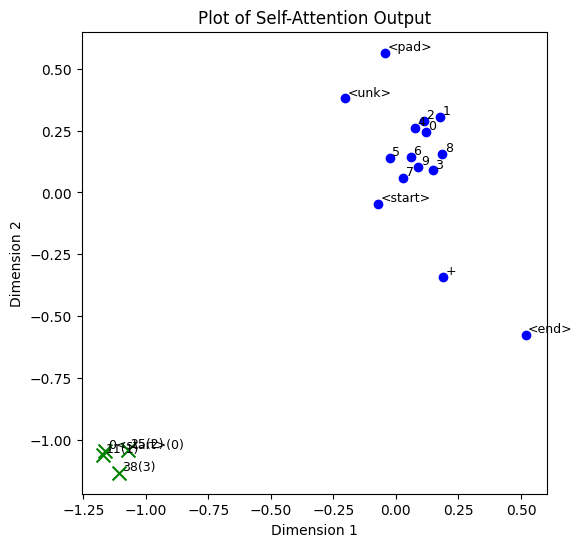

[[[-1.2235744  -0.7820783  -1.1162622   1.895791   -2.2671883
    0.29295468 -0.20709974  1.6461203  -0.01105351  0.58928543
    0.16213727 -1.2689083   1.7458565  -1.1919972   1.0548117
   -1.1694788 ]]

 [[ 0.07232238  0.21933964 -0.7113209   0.7821585  -3.1552367
    1.5661597   0.462155    1.3344882  -1.0731318   0.60385203
    0.49453002  0.3692924   0.57415664 -3.2063777   0.4466482
   -1.6625884 ]]

 [[-0.387439   -1.1982222  -0.03664902  0.8989771  -1.643707
    2.01778    -0.59410655  1.3544968   0.34306625  0.16022359
   -0.49162152  0.04380311  2.104702   -4.2743177   0.8980214
   -0.9727268 ]]

 [[-0.37789968 -1.681336    0.10184901  0.10266192 -2.285345
    0.70694524  0.23728295  1.7688793  -0.8340738  -0.32416996
    0.27744013 -0.28162992  1.7488304  -2.4308233   2.0832448
   -1.7487732 ]]]
(4, 1, 16)
[[-1.2235744  -0.7820783 ]
 [ 0.07232238  0.21933964]
 [-0.387439   -1.1982222 ]
 [-0.37789968 -1.681336  ]]


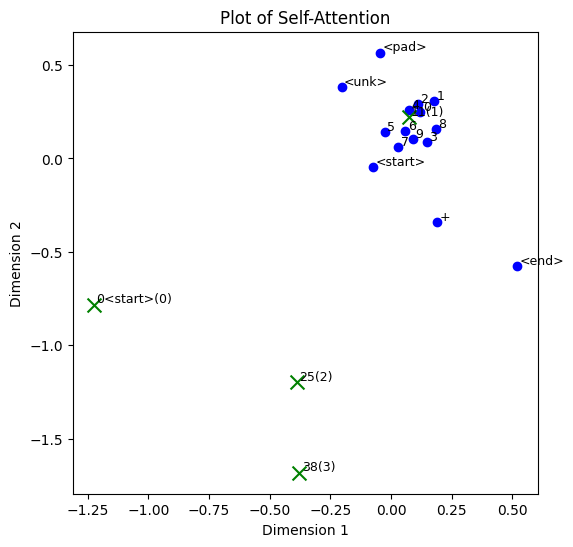

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 16])
After Attention: tensor([[[ 1.1570,  0.5520, -0.7962, -2.0389, -0.3259,  5.4502,  1.5775, -0.4958, -2.6470, -6.2693,
           2.8691,  4.4635,  5.1511, -9.0530,  1.2153, -0.2602]],

        [[ 0.6722, -0.4958,  1.0997, -0.3258,  0.3851,  3.4911, -2.2858,  0.5953,  4.9655, -3.8574,
          -3.9569,  0.3148,  5.4705, -8.9056,  4.5648, -5.1225]],

        [[-0.4125, -1.0987,  0.3951, -0.6986, -1.5700, -3.2429,  5.1034, -0.0292,  1.2977, -7.9707,
          -1.4331,  0.5795,  6.0863, -5.1295,  9.3872, -0.1594]],

        [[-0.3363, -1.4334,  0.6087, -0.6545,  1.7070,  2.5170, -4.0101,  0.6308,  5.0338, -6.0538,
          -4.6766,  0.9460,  7.3308, -6.5574,  3.8656, -1.0168]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 3.7896571e+00  3.1612761e+00 -1.6349750e+00 -3.9415207e+00
   -3.2362846e-01  

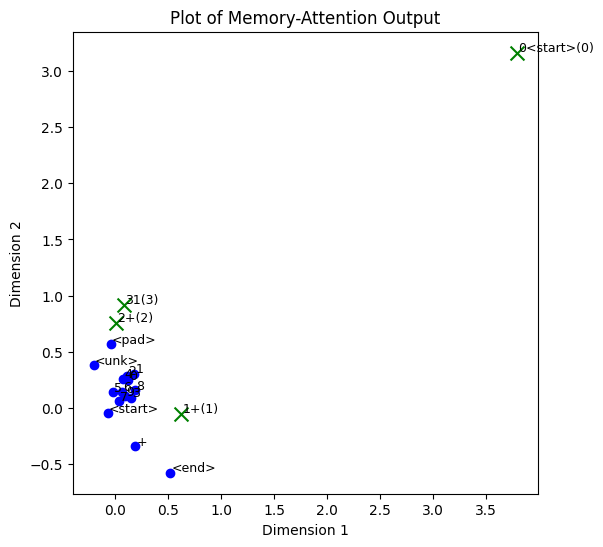

[[[ 1.1570175   0.5520309  -0.79620254 -2.0388753  -0.3259198
    5.45015     1.5774596  -0.4957972  -2.6470108  -6.269288
    2.8691316   4.463516    5.151147   -9.052971    1.2153164
   -0.26015958]]

 [[ 0.67215675 -0.4957655   1.0997009  -0.32578868  0.3851496
    3.4911015  -2.2858088   0.59534824  4.9654655  -3.8574064
   -3.9569244   0.3148315   5.470522   -8.905562    4.5648427
   -5.122511  ]]

 [[-0.41253322 -1.0986655   0.39510685 -0.6985503  -1.5699918
   -3.2429419   5.1034465  -0.02923828  1.2976846  -7.97069
   -1.4330802   0.5795011   6.086335   -5.129469    9.3872175
   -0.15935253]]

 [[-0.33632213 -1.4333711   0.60869855 -0.6544675   1.7069994
    2.5169516  -4.0101385   0.63075554  5.0338197  -6.053777
   -4.676555    0.9460088   7.33077    -6.5573635   3.86558
   -1.0167836 ]]]
(4, 1, 16)
[[ 1.1570175   0.5520309 ]
 [ 0.67215675 -0.4957655 ]
 [-0.41253322 -1.0986655 ]
 [-0.33632213 -1.4333711 ]]


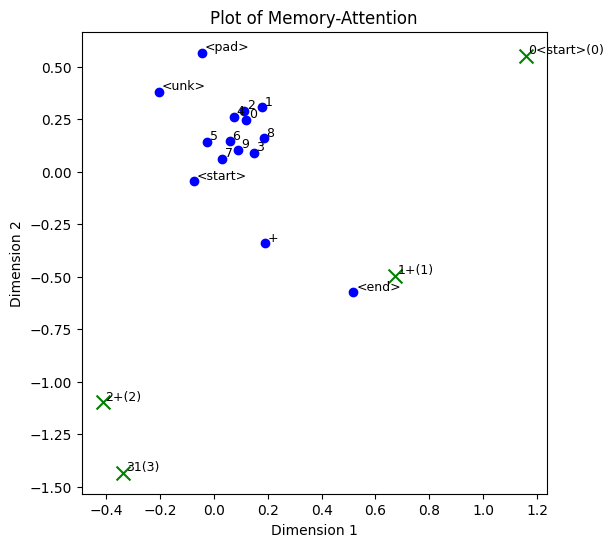

output.shape: torch.Size([1, 15])
output: tensor([[ -2.0515, -13.7787,  -3.8227,  -2.1380,  -1.5719,   9.3395, -10.3295,  -2.4954,  -1.6715,
          -3.0526,  -6.7587,  -7.8995,  -4.2940,  -6.9117,  10.2054]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 4
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4355e-01,  1.2639e+00,  1.2612e+00, -1.7843e+00,
           1

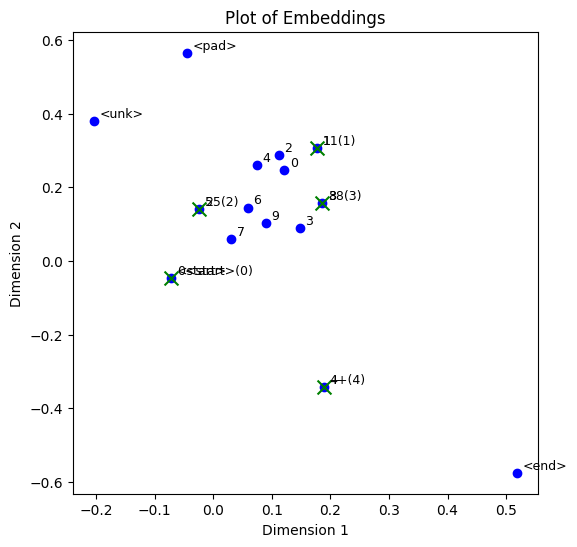

[[[-2.8924587e-01  8.1787038e-01 -1.2086385e+00  3.1065784e+00
   -5.8985609e-01 -4.9808490e-01  4.7985086e-01  3.4004815e+00
    1.1798354e+00  3.2258348e+00  2.1742761e-01  5.6577373e-01
    2.2401133e+00  3.1060188e+00 -6.8538731e-01  2.2112579e+00]]

 [[ 1.5492418e+00  1.7672291e+00 -4.9313539e-01 -1.7792642e-02
   -1.3663338e+00  6.9302917e-01  2.9270303e+00  8.6397308e-01
   -1.3560205e+00  2.2240398e+00  5.6327564e-01  4.6267147e+00
   -1.8858978e+00  1.1955233e+00 -2.2495263e+00  1.9995832e+00]]

 [[ 8.1110018e-01  1.4967456e-01  5.1914728e-01  5.4355025e-01
    1.2638816e+00  1.2611748e+00 -1.7843070e+00  1.2258816e+00
    9.5966351e-01  1.4488797e+00 -2.2743957e+00  3.3834002e+00
    1.5871867e+00 -6.5645987e-01 -2.0339627e+00  2.5939300e+00]]

 [[ 8.8381207e-01 -3.5988480e-01  5.4902810e-01 -5.4224956e-01
   -4.3385381e-01 -1.2565482e+00  1.8836070e+00  1.8194342e+00
   -1.7147171e+00 -1.5622085e-01 -2.3370215e-01  3.5962753e+00
    7.6969075e-01  1.2749015e+00  7.7970958e-0

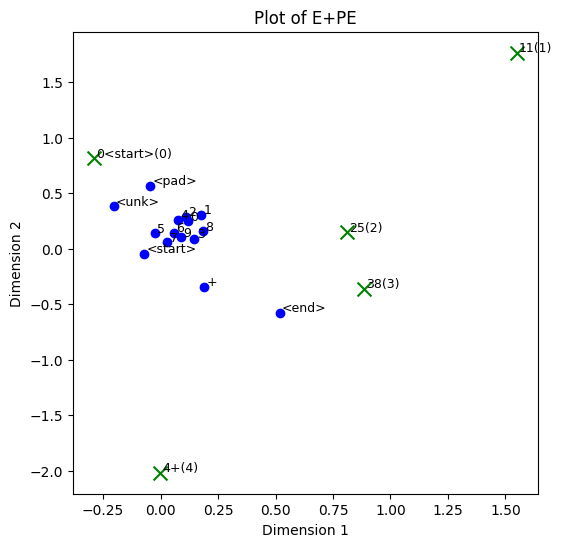

SelfAttention Layer
QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 5, 16])
WV.shape: torch.Size([1, 5, 16])
attn_weight.shape: torch.Size([1, 5, 5])
AV.shape: torch.Size([1, 5, 16])
[[[-0.5142262  -0.758995    0.35902685  0.18231861 -1.4850807
   -0.10905069 -0.25646803  1.2651966   0.6348871   0.12086686
   -0.37525198 -1.2812964   1.1243124  -1.3556029   0.9207314
   -2.4258432 ]]

 [[ 0.18116108 -0.45610416  1.3415823  -1.7003281   1.0700865
   -0.73806524 -0.14286768  0.7769874   1.891727    1.5536277
   -1.6298447   0.8806575  -0.91072726  1.6970923  -1.8310192
   -1.9151591 ]]

 [[-0.13463792 -0.61167186  0.71606314 -0.96010745 -0.29123235
   -0.16972949 -0.00908647  1.0539731   1.415678    0.74720037
   -0.7499097  -0.07421733  0.1447571   0.42958078 -0.15356451
   -2.3057127 ]]

 [[ 0.1976566  -0.49393457  1.318745   -1.8984077   1.0919644
   -0.36227745  0.0162717   0.976913    2.148839    1.6142263
   -1.4375132   0.7173067  -0.7623724   1.8019476  -1.7101922
   -2

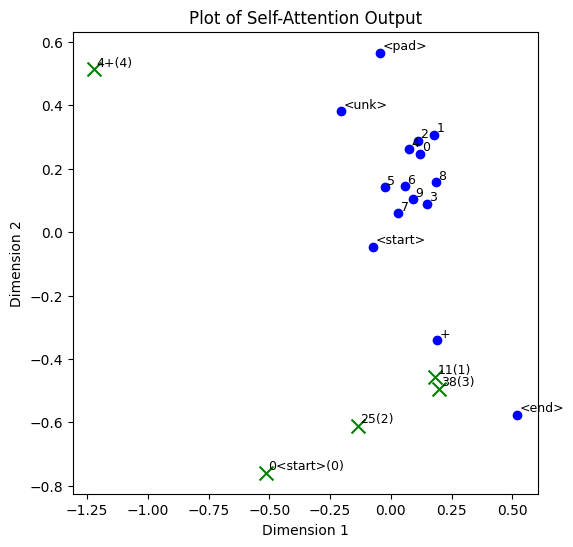

[[[-1.4111191  -0.9802749  -1.1796782   1.5574569  -1.9621845
   -0.55207103 -0.28054693  2.0043602   0.5314569   1.2893311
   -0.39617455 -0.79063356  1.3905965   1.1134946  -0.2201895
   -1.2842792 ]]

 [[ 0.6819971   0.2966442   0.34995955 -1.3165206  -0.6975206
    0.09889188  0.3224922   0.31949455 -0.16030344  1.2613101
   -0.57875     2.2570233  -1.3870463   2.0469966  -2.2741358
   -0.61282754]]

 [[ 0.14260845 -1.268447    0.9274259  -0.7182079   0.08101462
    1.0432373  -0.7877262   0.9747686   1.2019684   0.97874224
   -1.6755526   1.8319091   0.7724016  -0.8137108  -1.7308853
   -0.31413323]]

 [[ 0.3720551  -1.7541344   1.3250841  -2.1442885  -0.21330506
   -1.2338655   0.22773695  1.1292542  -0.21186648  0.49981555
   -1.0154246   2.240239   -0.27349105  2.914141   -0.87557006
   -0.69457746]]

 [[-2.0680394  -3.465069    2.7877958   0.04621487 -1.6564387
    2.6326628  -0.11080196  0.56158817 -0.47716522  0.86891836
    0.1333668   1.0479149   1.1122183  -1.1341381  -0.

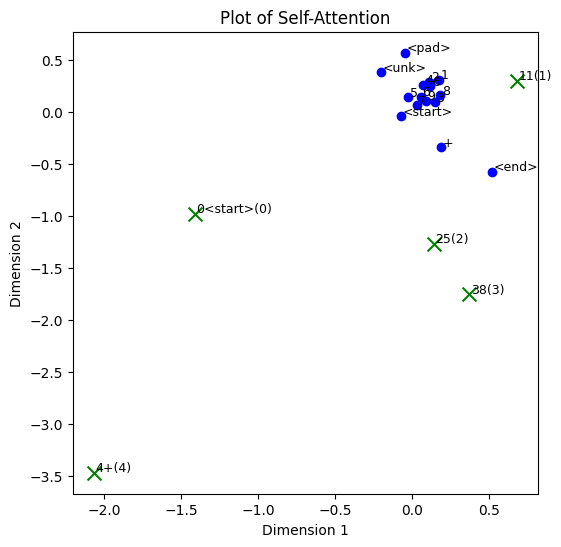

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 16])
After Attention: tensor([[[ 1.3174,  0.6918, -0.9497, -2.3220, -0.1542,  5.3697,  1.4547, -0.4807, -3.1620, -5.9849,
           3.1806,  5.1395,  4.8995, -8.2529, -0.4632,  0.2442]],

        [[ 1.4462, -0.2714,  1.7628, -4.6034,  3.9047,  3.2893, -3.2812, -0.4588,  6.0311, -3.6557,
          -6.1407,  4.9035,  1.8260, -2.1130, -2.5565, -3.6082]],

        [[ 0.6557, -1.6203,  1.5632, -5.0649,  1.0643, -2.0488,  4.9920, -0.5115,  3.1885, -7.9700,
          -4.4595,  6.2039,  4.2760, -2.7178,  2.1265, -0.2297]],

        [[ 1.1740, -0.8490,  0.7934, -4.3014,  3.2188,  3.2269, -3.1147, -0.1718,  2.1570, -6.8181,
          -3.8476,  6.6144,  5.2856, -4.0382, -2.0333,  0.7714]],

        [[-1.3439, -2.5385,  2.2599, -1.0685,  2.2555,  5.8178, -3.9421, -0.1952,  3.8861, -4.3599,
          -3.4115,  3.4205,  6.1445, -5.89

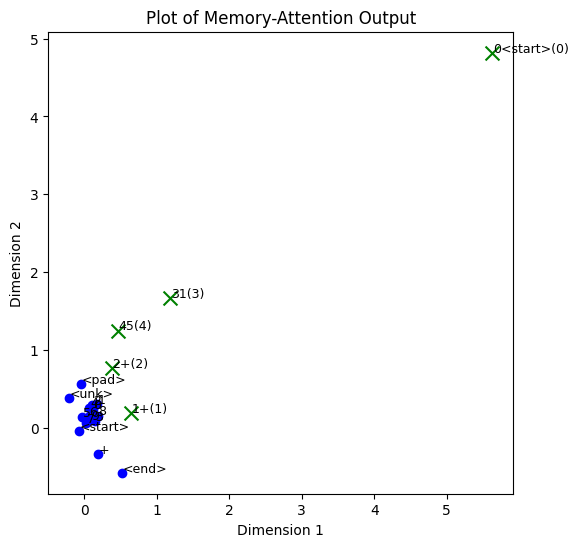

[[[ 1.3173984   0.6918173  -0.94965726 -2.3220425  -0.15416168
    5.369678    1.4546783  -0.4806912  -3.1620073  -5.9848886
    3.1805763   5.139537    4.8994837  -8.252923   -0.46324712
    0.2441611 ]]

 [[ 1.4461828  -0.27138454  1.7627504  -4.6033745   3.90474
    3.289268   -3.281199   -0.4587985   6.0310783  -3.6557324
   -6.140714    4.9035034   1.8260142  -2.1130307  -2.5564544
   -3.608229  ]]

 [[ 0.6556976  -1.6202574   1.5632052  -5.064907    1.064343
   -2.0488415   4.992025   -0.51152766  3.1884663  -7.970003
   -4.45952     6.2038856   4.2760234  -2.7178023   2.1265323
   -0.22966684]]

 [[ 1.1739961  -0.8489842   0.7934434  -4.3014326   3.21876
    3.2269018  -3.1147046  -0.17182201  2.1570382  -6.8180637
   -3.8476233   6.6144314   5.2855673  -4.0381823  -2.0333066
    0.77141637]]

 [[-1.3438995  -2.538529    2.2598555  -1.0684539   2.2555118
    5.8177986  -3.9421318  -0.19523914  3.8861034  -4.3598986
   -3.4115376   3.4205081   6.1444507  -5.897086   -0.4995747
  

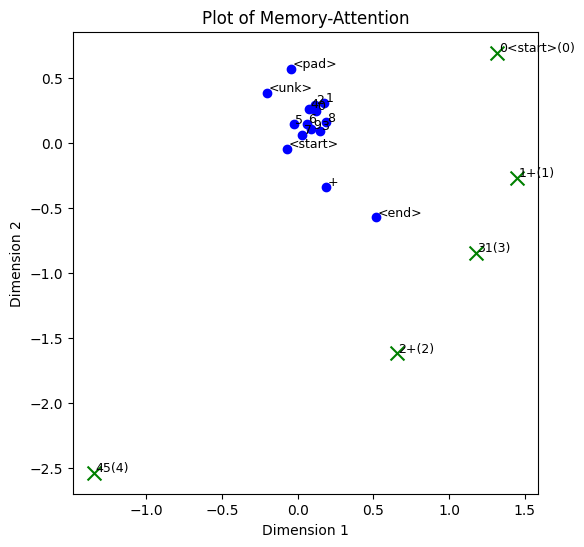

output.shape: torch.Size([1, 15])
output: tensor([[ 3.6733e-03, -8.8399e+00,  1.0020e+00, -1.6592e+00,  6.7108e-01,  1.1149e+01, -3.3209e+00,
          1.1905e+00, -3.9807e+00,  4.6942e-02, -7.7105e+00, -7.5341e+00, -6.2416e+00, -1.1000e+01,
          1.0945e+01]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4

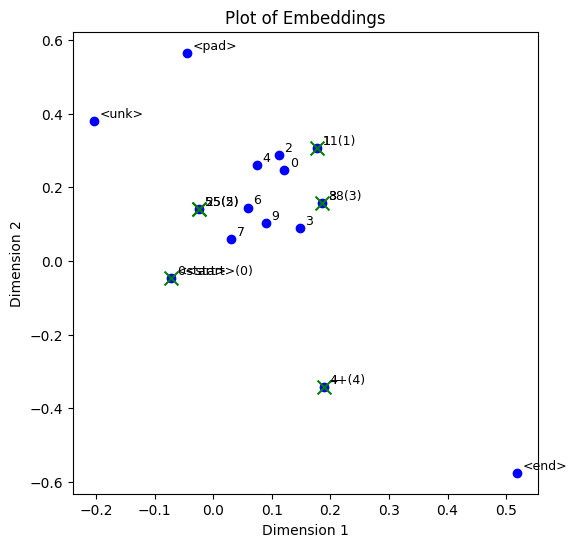

[[[-2.8924587e-01  8.1787038e-01 -1.2086385e+00  3.1065784e+00
   -5.8985609e-01 -4.9808490e-01  4.7985086e-01  3.4004815e+00
    1.1798354e+00  3.2258348e+00  2.1742761e-01  5.6577373e-01
    2.2401133e+00  3.1060188e+00 -6.8538731e-01  2.2112579e+00]]

 [[ 1.5492418e+00  1.7672291e+00 -4.9313539e-01 -1.7792642e-02
   -1.3663338e+00  6.9302917e-01  2.9270303e+00  8.6397308e-01
   -1.3560205e+00  2.2240398e+00  5.6327564e-01  4.6267147e+00
   -1.8858978e+00  1.1955233e+00 -2.2495263e+00  1.9995832e+00]]

 [[ 8.1110018e-01  1.4967456e-01  5.1914728e-01  5.4355025e-01
    1.2638816e+00  1.2611748e+00 -1.7843070e+00  1.2258816e+00
    9.5966351e-01  1.4488797e+00 -2.2743957e+00  3.3834002e+00
    1.5871867e+00 -6.5645987e-01 -2.0339627e+00  2.5939300e+00]]

 [[ 8.8381207e-01 -3.5988480e-01  5.4902810e-01 -5.4224956e-01
   -4.3385381e-01 -1.2565482e+00  1.8836070e+00  1.8194342e+00
   -1.7147171e+00 -1.5622085e-01 -2.3370215e-01  3.5962753e+00
    7.6969075e-01  1.2749015e+00  7.7970958e-0

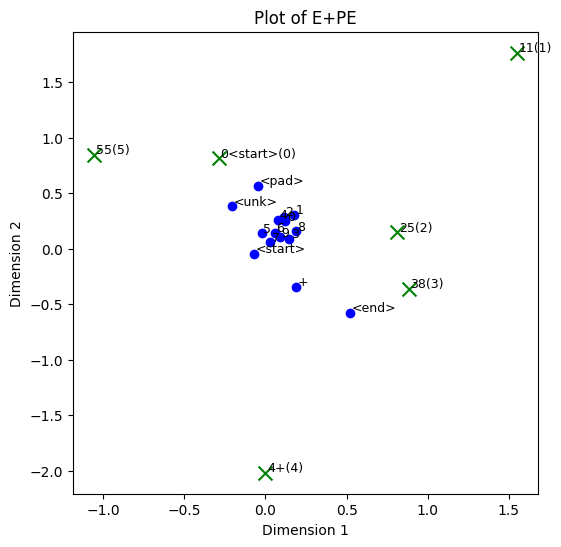

SelfAttention Layer
QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 6, 16])
WV.shape: torch.Size([1, 6, 16])
attn_weight.shape: torch.Size([1, 6, 6])
AV.shape: torch.Size([1, 6, 16])
[[[-0.6231109   0.02235531 -1.1956344   0.79829186 -2.6309474
    1.9945107   0.9226136   1.4089012   0.16335587 -2.527503
    1.5478088  -1.9186198   1.7683953  -1.8186442   4.6492357
   -5.2647057 ]]

 [[-0.22987115 -0.01824863 -0.28186578 -0.3484553  -0.9953397
    1.1261816   0.6808586   1.1156243   0.9443348  -1.0975457
    0.39690775 -0.6196478   0.5343842  -0.09617627  2.2500443
   -4.270566  ]]

 [[-0.43484858 -0.02351739 -0.8088341   0.19005907 -1.9228177
    1.6631483   0.864784    1.2921389   0.58635175 -1.8603504
    1.0997972  -1.2779163   1.2301344  -0.9403372   3.6224818
   -4.800133  ]]

 [[-0.09536925 -0.17506121  0.19059579 -0.88690805 -0.360228
    0.817159    0.53970337  1.1474462   1.4007082  -0.26059693
   -0.08348837 -0.2780476   0.19934769  0.512605    1.1047239
   -3.7245

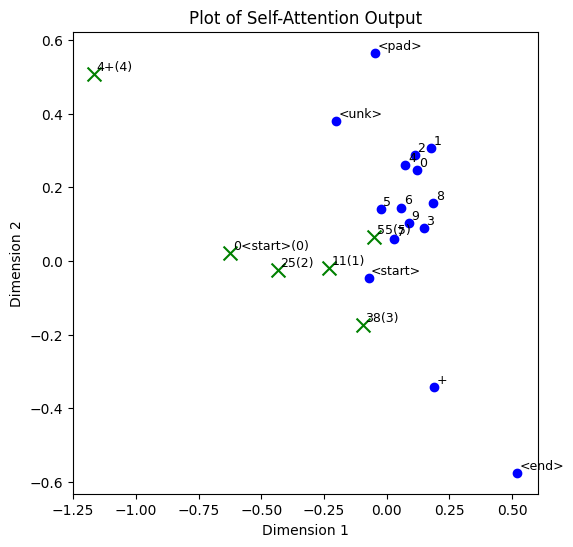

[[[-1.2092605  -0.25384393 -1.9094146   1.4530118  -2.1187294
    0.89249414 -0.01884998  1.5437113   0.12552632  0.01925729
    0.33447123 -0.8974413   1.3094934   0.40845418  1.6642984
   -3.6677125 ]]

 [[ 0.59462214  0.9862836  -1.0098602  -0.7459944  -2.1078746
    1.5034734   0.7115926   0.68244153 -0.7679006   0.3429639
    0.1962947   2.0977273  -1.0258614   0.6347124  -0.26402414
   -3.6853626 ]]

 [[-0.11247122 -0.6120947  -0.5233238   0.15431921 -1.0329169
    2.80197    -0.5600694   1.2526456   0.72593224 -0.4033426
   -0.8304566   1.1991289   1.5403626  -2.6906857   1.0246407
   -3.8642352 ]]

 [[ 0.21484433 -1.6278737   0.42664742 -1.7350994  -1.2692316
   -0.43999922  0.5084066   1.5810676  -0.78881824 -0.5032788
   -0.46124685  2.0736575   0.33138427  1.8250401   1.2372421
   -3.147834  ]]

 [[-1.6420377  -2.8877249   1.843415   -0.16040637 -1.4768864
    3.1022584   0.08516596  0.46899396 -0.26319653  0.15824343
    0.5254855   0.39258784  1.1328092  -1.6484115   1.238

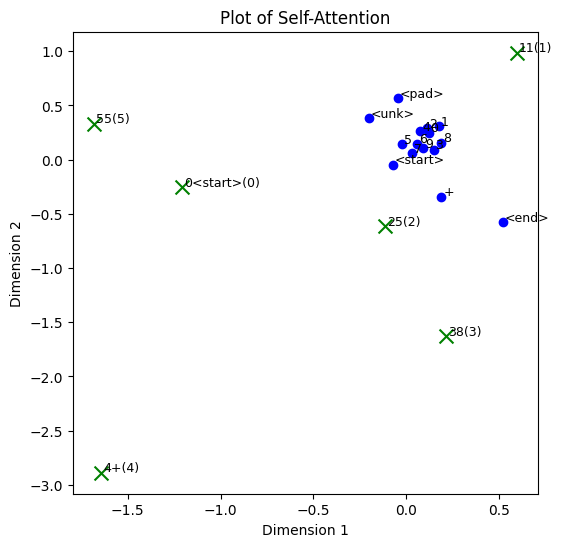

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 16])
After Attention: tensor([[[ 1.3220,  0.9010, -1.1066, -2.2264, -0.1731,  5.6142,  1.5824, -0.5117, -3.1006, -6.3814,
           3.4782,  4.9008,  4.7694, -8.0968,  0.2968, -0.7947]],

        [[ 1.1524,  0.4413,  0.6017, -2.3826,  2.3661,  4.9298, -3.4321,  0.1215,  5.9757, -4.0451,
          -5.0152,  3.2158,  2.7338, -3.7205,  1.3892, -8.6416]],

        [[ 0.3504, -0.2876, -0.1321, -2.5052, -0.4854,  1.4258,  4.7664, -0.1278,  2.1848, -8.6654,
          -1.3115,  3.7551,  4.8777, -4.8884,  7.3917, -7.2979]],

        [[ 0.7017, -0.9558,  0.4373, -3.3138,  2.7444,  3.1784, -3.8358,  0.3369,  3.5902, -7.4416,
          -4.7164,  5.6099,  6.0311, -3.3865,  1.0897, -2.8901]],

        [[ 0.3303, -0.7641,  0.5926, -2.1732,  1.1159,  6.9172, -0.7202, -0.4824, -0.1178, -6.2560,
           0.9429,  4.6616,  5.8333, -8.46

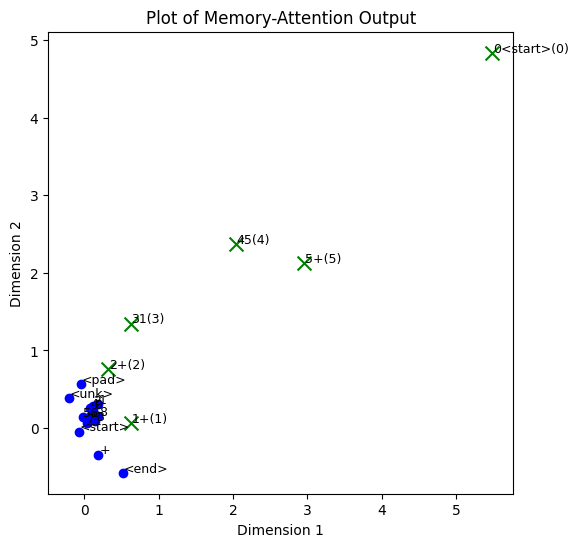

[[[ 1.3220339   0.9009617  -1.1065704  -2.226361   -0.17312875
    5.6141524   1.5823697  -0.51166284 -3.1006322  -6.3814034
    3.4781816   4.900807    4.7694273  -8.096822    0.29678944
   -0.79465246]]

 [[ 1.1524391   0.44132656  0.601676   -2.3825963   2.3661158
    4.9297743  -3.4321287   0.12145983  5.9757366  -4.045142
   -5.0151925   3.2157917   2.7338197  -3.7204523   1.3892303
   -8.641645  ]]

 [[ 0.35043353 -0.28762832 -0.13209714 -2.505195   -0.485415
    1.4258102   4.766355   -0.12780139  2.1848073  -8.665407
   -1.3114905   3.7551088   4.8776927  -4.8883543   7.3916554
   -7.2979407 ]]

 [[ 0.7017335  -0.9558486   0.4373029  -3.3137846   2.7444153
    3.1784148  -3.8358462   0.3369124   3.590201   -7.4416127
   -4.7163763   5.6098804   6.031079   -3.3865473   1.0897
   -2.8901424 ]]

 [[ 0.33032015 -0.76408786  0.5926159  -2.1732187   1.115873
    6.9171743  -0.7202344  -0.48235744 -0.11783044 -6.2559924
    0.9429373   4.661584    5.8332744  -8.461659    0.62843025
  

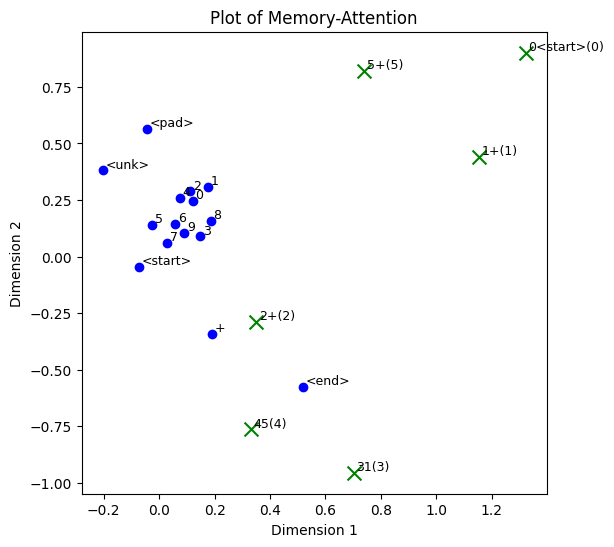

output.shape: torch.Size([1, 15])
output: tensor([[  4.4045,   5.1447,   4.5652,   2.2401,   4.8263,   4.5570,   3.3280,   4.2062,   3.7308,
           3.7640, -11.6280, -10.8860, -12.1780, -18.7681,  16.2287]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 6
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14],
        [ 5],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4355e-01,  1.2639e+00,  1.2612e+0

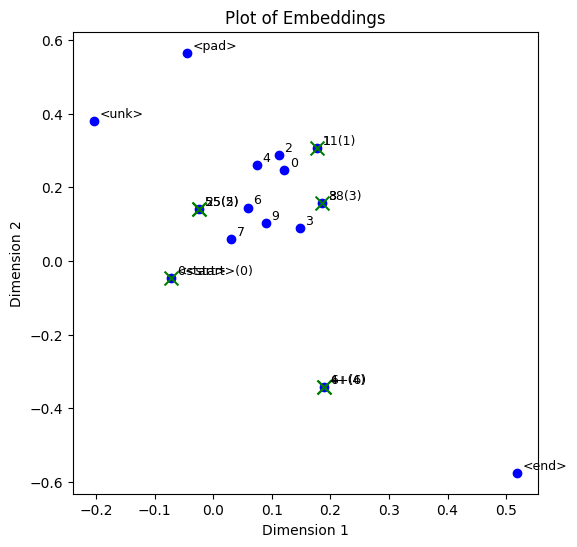

[[[-2.8924587e-01  8.1787038e-01 -1.2086385e+00  3.1065784e+00
   -5.8985609e-01 -4.9808490e-01  4.7985086e-01  3.4004815e+00
    1.1798354e+00  3.2258348e+00  2.1742761e-01  5.6577373e-01
    2.2401133e+00  3.1060188e+00 -6.8538731e-01  2.2112579e+00]]

 [[ 1.5492418e+00  1.7672291e+00 -4.9313539e-01 -1.7792642e-02
   -1.3663338e+00  6.9302917e-01  2.9270303e+00  8.6397308e-01
   -1.3560205e+00  2.2240398e+00  5.6327564e-01  4.6267147e+00
   -1.8858978e+00  1.1955233e+00 -2.2495263e+00  1.9995832e+00]]

 [[ 8.1110018e-01  1.4967456e-01  5.1914728e-01  5.4355025e-01
    1.2638816e+00  1.2611748e+00 -1.7843070e+00  1.2258816e+00
    9.5966351e-01  1.4488797e+00 -2.2743957e+00  3.3834002e+00
    1.5871867e+00 -6.5645987e-01 -2.0339627e+00  2.5939300e+00]]

 [[ 8.8381207e-01 -3.5988480e-01  5.4902810e-01 -5.4224956e-01
   -4.3385381e-01 -1.2565482e+00  1.8836070e+00  1.8194342e+00
   -1.7147171e+00 -1.5622085e-01 -2.3370215e-01  3.5962753e+00
    7.6969075e-01  1.2749015e+00  7.7970958e-0

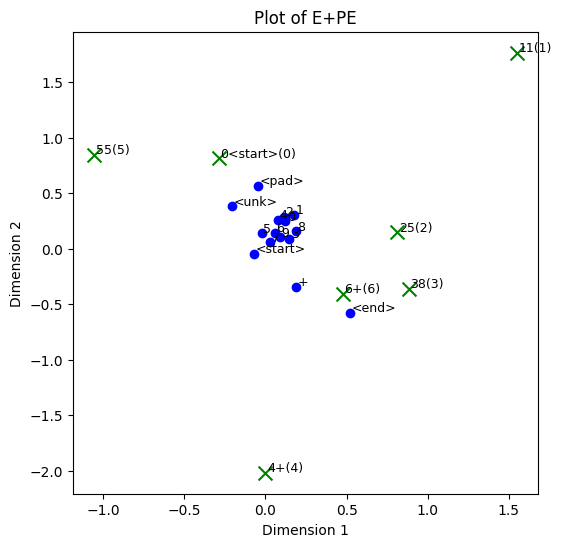

SelfAttention Layer
QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 7, 16])
WV.shape: torch.Size([1, 7, 16])
attn_weight.shape: torch.Size([1, 7, 7])
AV.shape: torch.Size([1, 7, 16])
[[[ 0.69921696  0.19309314  1.2212111  -0.3762196   0.22422679
    0.6132153  -0.17027059  0.04062848  0.5881067  -0.96118003
   -0.57301146  0.6110179  -0.9008517  -0.11517071 -0.01653281
   -3.1165943 ]]

 [[ 1.5004082   0.26803565  2.7464082  -1.3366277   2.1995258
   -0.3664425  -0.8064718  -0.75295365  1.0496905   0.28862557
   -2.0202875   2.3142598  -2.6554651   1.2962618  -3.1590965
   -1.7042168 ]]

 [[ 0.85658926  0.17655605  1.5312732  -0.74760693  0.7224333
    0.37808296 -0.2489925  -0.0812266   0.82904226 -0.5415156
   -0.9021227   1.0594119  -1.3016227   0.42145288 -0.7621758
   -2.7775774 ]]

 [[ 1.3018275   0.16122222  2.4967692  -1.4138806   1.9925957
   -0.27484637 -0.6463218  -0.465366    1.2227058   0.43070638
   -1.8636762   2.0244327  -2.325336    1.3431853  -2.837672
   -1

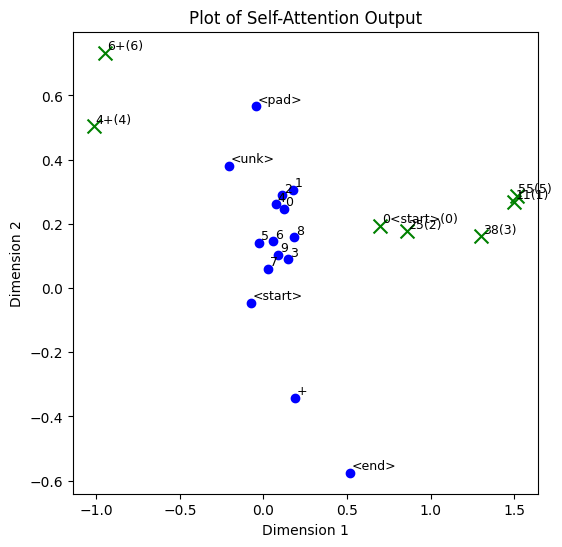

[[[-6.7810726e-01 -1.1485983e-01 -8.9085299e-01  1.6108922e+00
   -1.3496530e+00 -3.6492047e-01 -3.6231464e-01  1.8506235e+00
    6.4501047e-01  9.8516417e-01 -7.8519148e-01  2.6773182e-01
    3.5524398e-01  3.3465590e+00 -1.3509130e+00 -3.2016501e+00]]

 [[ 1.3379600e+00  7.3979360e-01  1.1554304e+00 -9.0617490e-01
   -1.4286560e-01  4.0225255e-01  1.4270280e-01 -2.7537251e-01
   -4.6071169e-01  6.8665040e-01 -5.6152362e-01  2.4380050e+00
   -1.7056333e+00  1.4635986e+00 -2.3744190e+00 -2.8637698e-01]]

 [[ 9.9132413e-01 -3.4940994e-01  1.5765616e+00 -5.0031966e-01
    6.7209667e-01  1.4362320e+00 -7.8249687e-01  2.7211773e-01
    7.3579556e-01  3.0089658e-01 -1.5728388e+00  2.3270910e+00
   -3.2552361e-02 -7.0978647e-01 -1.9284116e+00 -8.1811875e-01]]

 [[ 1.2411448e+00 -8.5166633e-01  2.1529031e+00 -1.5102458e+00
    3.2375392e-01 -8.5529345e-01  4.9723670e-02  3.1193858e-01
   -6.4854366e-01 -9.6439086e-03 -9.9594092e-01  2.6634328e+00
   -9.0524817e-01  2.1796129e+00 -1.3158356e+0

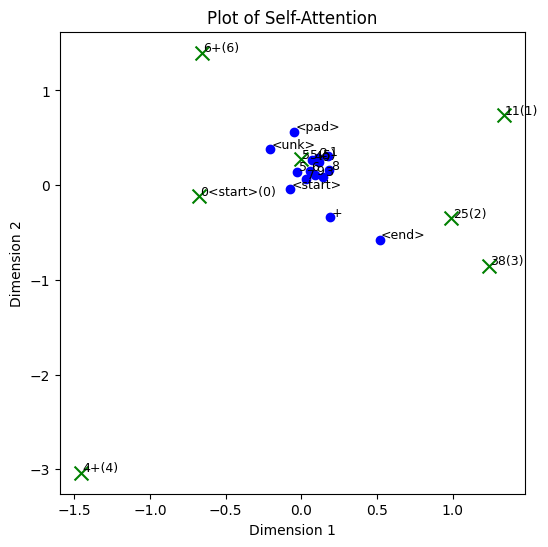

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 16])
After Attention: tensor([[[ 1.5234,  0.9934, -0.9757, -2.3171, -0.0225,  5.4172,  1.4161, -0.4960, -3.2075, -6.3576,
           3.0625,  5.6703,  4.5978, -7.4262, -1.2489, -0.6150]],

        [[ 0.0930, -2.7836,  3.2367, -1.1711,  4.3693, -2.2784, -2.3343,  0.1699,  6.1670,  1.5808,
          -2.6417, -5.2302, -0.0770,  3.1403,  3.3725, -7.6140]],

        [[-0.1956, -3.2365,  3.2974, -1.7255,  3.2316, -4.8680,  2.2258,  0.0156,  5.0451, -0.7354,
          -1.8667, -4.2964,  0.2594,  3.8393,  5.5744, -7.4499]],

        [[-0.3032, -3.4492,  3.1818, -1.3195,  4.5590, -3.7351, -2.7380,  0.3493,  5.5579,  0.2075,
          -3.1218, -4.4267,  1.0929,  4.3428,  3.6514, -5.3175]],

        [[ 0.4629, -0.8468,  0.7728, -2.3659,  1.3039,  6.9495, -0.6079, -0.5241, -0.1839, -6.1931,
           1.0505,  4.7276,  5.6399, -8.40

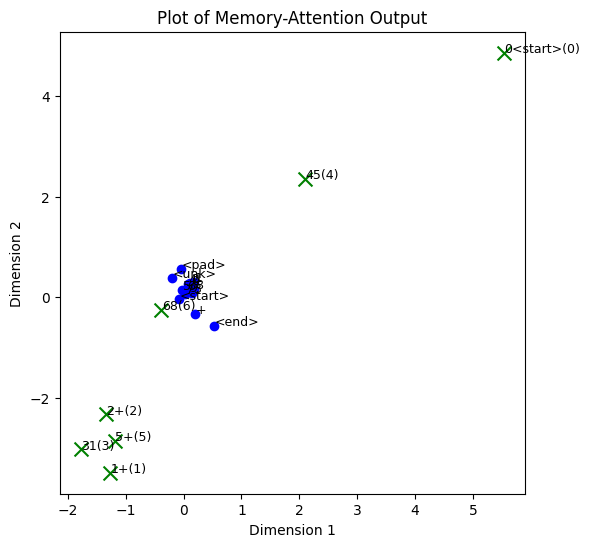

[[[ 1.5233504   0.9934302  -0.97568023 -2.317093   -0.02253477
    5.4171557   1.416055   -0.4959674  -3.2075021  -6.357595
    3.062547    5.670336    4.5978174  -7.426233   -1.2489175
   -0.6149925 ]]

 [[ 0.09300748 -2.7835705   3.2366824  -1.1710615   4.3693004
   -2.2783954  -2.3343258   0.16985469  6.166959    1.5807965
   -2.641695   -5.23016    -0.07697915  3.1402628   3.3725076
   -7.6139874 ]]

 [[-0.19556953 -3.2364812   3.297437   -1.7255244   3.2316034
   -4.8679957   2.2258348   0.01558245  5.045128   -0.73536754
   -1.8666593  -4.296404    0.2594317   3.8392792   5.574421
   -7.449891  ]]

 [[-0.3031552  -3.4491878   3.1817775  -1.3194814   4.5590177
   -3.7350833  -2.7379603   0.34925276  5.557946    0.20745444
   -3.121837   -4.4266887   1.0928625   4.3427687   3.6514242
   -5.3175073 ]]

 [[ 0.4629114  -0.84684336  0.7727903  -2.3658574   1.303911
    6.9495234  -0.6078589  -0.52409303 -0.18389007 -6.193078
    1.0504597   4.7276077   5.639869   -8.402919    0.4461664

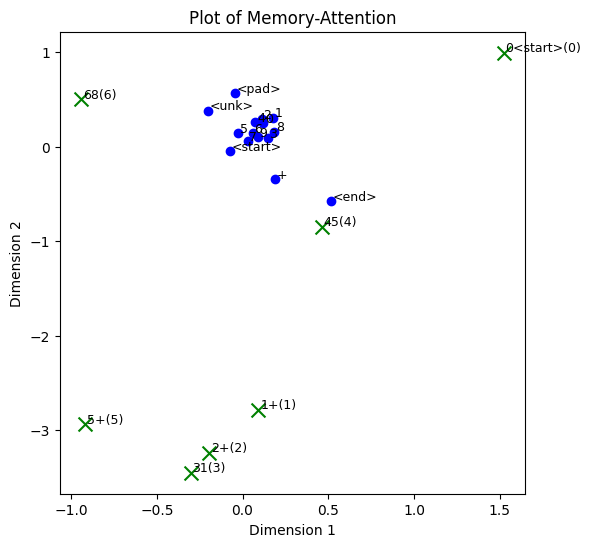

output.shape: torch.Size([1, 15])
output: tensor([[ -5.2364, -12.6524,  -3.2062,  -6.2723,  -4.0075,   4.8096,  -9.1331,  -5.5321,  -7.7855,
          -4.6556,  -9.0234,  -5.9200,  -7.2712,   4.1815,  15.1708]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 7
ys: tensor([[12],
        [ 1],
        [ 5],
        [ 8],
        [14],
        [ 5],
        [14],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-2.8925e-01,  8.1787e-01, -1.2086e+00,  3.1066e+00, -5.8986e-01, -4.9808e-01,  4.7985e-01,
           3.4005e+00,  1.1798e+00,  3.2258e+00,  2.1743e-01,  5.6577e-01,  2.2401e+00,  3.1060e+00,
          -6.8539e-01,  2.2113e+00]],

        [[ 1.5492e+00,  1.7672e+00, -4.9314e-01, -1.7793e-02, -1.3663e+00,  6.9303e-01,  2.9270e+00,
           8.6397e-01, -1.3560e+00,  2.2240e+00,  5.6328e-01,  4.6267e+00, -1.8859e+00,  1.1955e+00,
          -2.2495e+00,  1.9996e+00]],

        [[ 8.1110e-01,  1.4967e-01,  5.1915e-01,  5.4355e-01,  1.2639e+

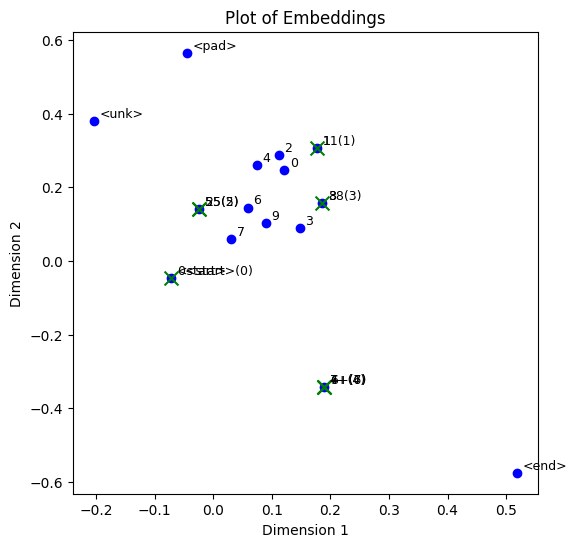

[[[-2.8924587e-01  8.1787038e-01 -1.2086385e+00  3.1065784e+00
   -5.8985609e-01 -4.9808490e-01  4.7985086e-01  3.4004815e+00
    1.1798354e+00  3.2258348e+00  2.1742761e-01  5.6577373e-01
    2.2401133e+00  3.1060188e+00 -6.8538731e-01  2.2112579e+00]]

 [[ 1.5492418e+00  1.7672291e+00 -4.9313539e-01 -1.7792642e-02
   -1.3663338e+00  6.9302917e-01  2.9270303e+00  8.6397308e-01
   -1.3560205e+00  2.2240398e+00  5.6327564e-01  4.6267147e+00
   -1.8858978e+00  1.1955233e+00 -2.2495263e+00  1.9995832e+00]]

 [[ 8.1110018e-01  1.4967456e-01  5.1914728e-01  5.4355025e-01
    1.2638816e+00  1.2611748e+00 -1.7843070e+00  1.2258816e+00
    9.5966351e-01  1.4488797e+00 -2.2743957e+00  3.3834002e+00
    1.5871867e+00 -6.5645987e-01 -2.0339627e+00  2.5939300e+00]]

 [[ 8.8381207e-01 -3.5988480e-01  5.4902810e-01 -5.4224956e-01
   -4.3385381e-01 -1.2565482e+00  1.8836070e+00  1.8194342e+00
   -1.7147171e+00 -1.5622085e-01 -2.3370215e-01  3.5962753e+00
    7.6969075e-01  1.2749015e+00  7.7970958e-0

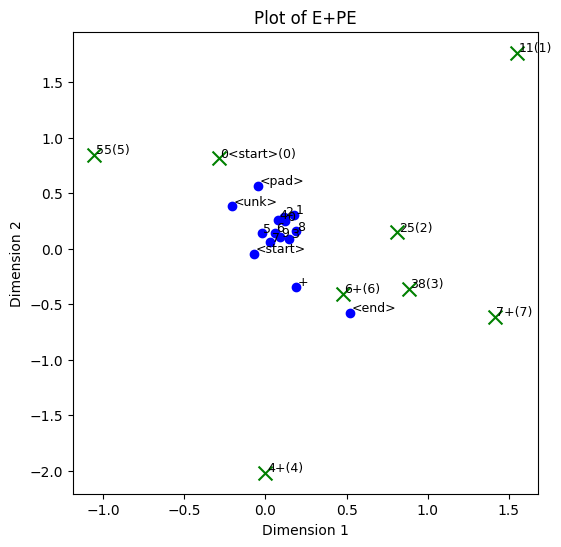

SelfAttention Layer
QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 8, 16])
WV.shape: torch.Size([1, 8, 16])
attn_weight.shape: torch.Size([1, 8, 8])
AV.shape: torch.Size([1, 8, 16])
[[[ 1.540295   -0.23061651  2.9313347  -0.74591774  1.332142
    0.2526955  -0.5528124  -0.73830855  0.85584396 -0.3284537
   -1.0877929   1.5460906  -1.5057651  -0.35584417 -1.2527056
   -2.0658646 ]]

 [[ 2.2275157  -0.37163806  4.284113   -1.3087686   2.6318007
   -0.314658   -0.9819102  -1.3968724   1.1631587   0.46596363
   -1.9186752   2.6584723  -2.50525     0.15094721 -3.105237
   -1.0309247 ]]

 [[ 1.7827092  -0.3203122   3.4191     -1.0086563   1.8018049
    0.06213142 -0.666761   -0.9504663   1.031637    0.00960979
   -1.3564694   1.956907   -1.8287377  -0.12461024 -1.8748077
   -1.6894234 ]]

 [[ 2.0433526  -0.34926385  3.9791281  -1.3503714   2.4782295
   -0.27532303 -0.88180065 -1.1783581   1.2356141   0.5155502
   -1.8529605   2.4741552  -2.3591883   0.30914956 -2.952142
   -1.1853

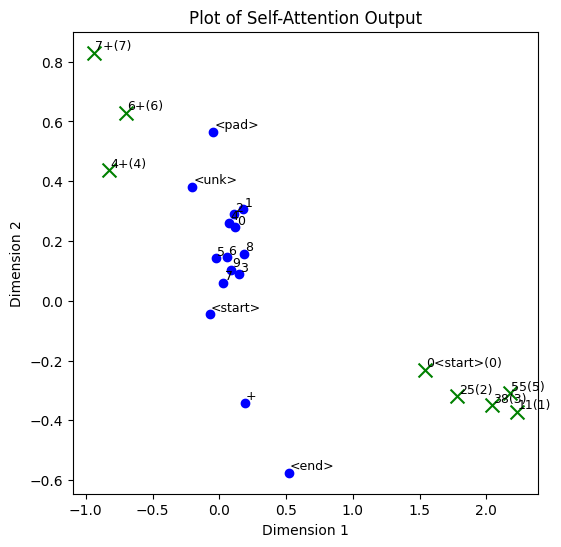

[[[ 2.1096180e-01 -8.4994966e-01  1.0270662e+00  1.1279318e+00
   -4.8402932e-01 -8.2252645e-01 -5.3157705e-01  1.1207216e+00
    7.6346099e-01  1.3028955e+00 -1.1353561e+00  9.1269577e-01
   -1.6454364e-01  2.7076077e+00 -2.4840851e+00 -1.5317583e+00]]

 [[ 1.6203353e+00  2.2589226e-01  1.8875506e+00 -9.1032428e-01
   -2.4773257e-02  3.7856874e-01  8.5066088e-02 -5.3048646e-01
   -4.4631940e-01  6.8510652e-01 -5.4252833e-01  2.4366088e+00
   -1.6289717e+00  5.2180630e-01 -2.3063912e+00  1.4766468e-01]]

 [[ 1.2830944e+00 -7.7281749e-01  2.4093685e+00 -5.7544810e-01
    9.0117657e-01  9.8220766e-01 -7.2922516e-01 -2.1850480e-01
    5.8891547e-01  4.1414881e-01 -1.3755597e+00  2.1359017e+00
   -2.5889647e-01 -1.0725927e+00 -2.0219684e+00  2.6432607e-01]]

 [[ 1.5711439e+00 -1.2744024e+00  2.9261749e+00 -1.3822321e+00
    4.6403986e-01 -7.7350336e-01 -3.5060219e-02 -7.9351738e-02
   -6.3053304e-01  4.8929121e-04 -9.2296141e-01  2.5833335e+00
   -8.6231494e-01  9.6598345e-01 -1.2773886e+0

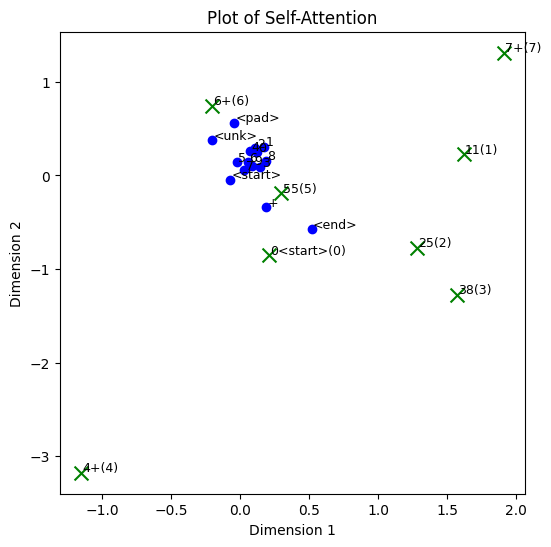

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 16])
After Attention: tensor([[[  1.7637,   0.7098,  -0.4663,  -2.5102,   0.3083,   5.1515,   1.3012,  -0.6293,  -3.1166,
           -6.2732,   2.7949,   5.8987,   4.3709,  -7.6668,  -1.8358,   0.0860]],

        [[ -0.5506,  -3.2198,   2.7095,  -0.2272,   3.2983,  -3.5965,  -0.8070,   0.2703,   4.3185,
            2.8203,  -0.0462,  -7.1143,  -0.2186,   3.8503,   4.8977,  -6.4937]],

        [[ -0.7370,  -3.4875,   2.7042,  -0.1233,   3.3345,  -3.9413,  -0.3436,   0.2753,   4.1707,
            2.3657,  -0.0641,  -7.1628,   0.3436,   3.4869,   5.3986,  -6.0221]],

        [[ -0.6196,  -3.6316,   2.8429,  -0.3815,   3.4576,  -4.0225,  -0.9432,   0.3455,   4.0711,
            2.2339,  -0.2649,  -6.7552,   0.2744,   4.0219,   5.1632,  -5.8052]],

        [[  0.2127,  -1.7419,   1.5778,  -2.3069,   2.0864,   6.8170,  -1.4727

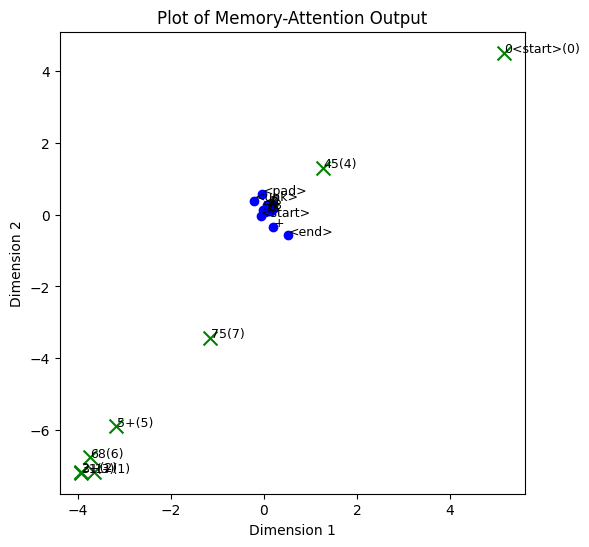

[[[  1.7637119    0.7098183   -0.46628773  -2.5101626    0.30829006
     5.1515217    1.3011554   -0.6293477   -3.1165628   -6.2731934
     2.7948508    5.89868      4.3708725   -7.6667967   -1.8357716
     0.08601267]]

 [[ -0.55062705  -3.2198353    2.7094815   -0.22723225   3.2982962
    -3.5964649   -0.80702716   0.2702562    4.3185315    2.8203356
    -0.0461982   -7.1143026   -0.21857737   3.8502617    4.8976974
    -6.4937086 ]]

 [[ -0.73695356  -3.4874783    2.7041662   -0.12325629   3.33454
    -3.9412656   -0.34362128   0.27531093   4.1707287    2.3657427
    -0.06410637  -7.1627846    0.34358397   3.4869406    5.398588
    -6.022106  ]]

 [[ -0.6195939   -3.6315506    2.84292     -0.381483     3.4576364
    -4.0225425   -0.94315994   0.34546608   4.071054     2.2339416
    -0.26492408  -6.7551746    0.27437672   4.0218663    5.1632214
    -5.8051715 ]]

 [[  0.21267673  -1.7418786    1.5778116   -2.3068984    2.0863798
     6.8170238   -1.4727228   -0.43439516   1.2471257  

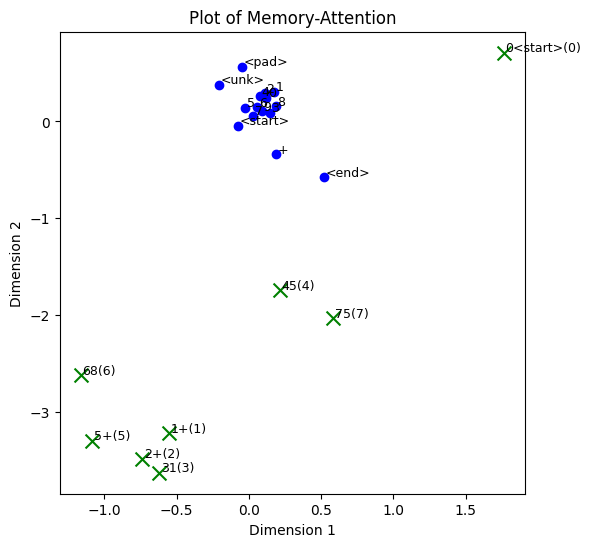

output.shape: torch.Size([1, 15])
output: tensor([[ -8.9141, -15.5879,  -8.7952,  -7.2806, -10.5784,  -4.1147, -13.1084, -10.2171,  -9.2522,
          -9.2543,  -8.4250,  -4.5901,  -2.7336,  22.4450,  14.8776]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 13

------------------

Input: ++15+85
Decoded sequence: 158+5++


In [65]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    print(f"After Attention: {tgt}")
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, src=src, title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [37]:
import torch
from torch import nn
import torch.nn.functional as F


In [38]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [39]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

torch.Size([2, 5, 4])
tensor([[[ 1.3548,  2.3551, -0.4238, -0.9511],
         [-0.0532, -0.9097,  1.8184, -2.8245],
         [-1.6209, -0.9735,  0.2784,  1.5171],
         [ 0.5290,  1.9066,  0.2519, -1.3132],
         [-0.1575,  0.3757, -0.8101,  0.7158]],

        [[ 0.6011,  0.0127,  0.4910, -0.7023],
         [-0.1652,  0.0426,  1.5995,  1.5830],
         [-0.6566, -1.1388, -2.0322, -0.6478],
         [ 1.0833, -0.3962,  0.4758, -0.5040],
         [-1.2494, -1.0060,  1.5583, -0.3713]]])


In [40]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



torch.Size([2, 5, 4])
tensor([[[ 0.4940,  0.4179,  0.4190, -0.2025],
         [ 0.6600,  0.7911,  0.4342, -0.3850],
         [ 0.1148,  0.0690,  0.0921, -0.0243],
         [ 0.5577,  0.5301,  0.4419, -0.2584],
         [ 0.2888,  0.2563,  0.2265, -0.1175]],

        [[-0.1175,  0.0587, -0.1582, -0.0061],
         [ 0.0286,  0.1192, -0.0538, -0.0878],
         [ 0.1877,  0.3321,  0.0189, -0.2161],
         [-0.0702,  0.0794, -0.1239, -0.0310],
         [ 0.0509,  0.2435, -0.0723, -0.1392]]], grad_fn=<TransposeBackward0>)


In [41]:
from pprint import pprint
pprint(list(model.named_parameters()))

[('in_proj_weight',
  Parameter containing:
tensor([[ 0.5222,  0.5955,  0.5218, -0.4626],
        [-0.2551, -0.3986,  0.1921,  0.2562],
        [ 0.2040, -0.4102, -0.4556,  0.3735],
        [-0.5191, -0.0213, -0.1347, -0.4117],
        [ 0.1068, -0.0335, -0.1975, -0.1884],
        [-0.4298,  0.0607,  0.3956,  0.1602],
        [-0.5975,  0.3526,  0.5739, -0.0568],
        [ 0.5358, -0.1508,  0.2135, -0.5927],
        [ 0.5221,  0.2310,  0.4229, -0.4160],
        [-0.4566,  0.5798,  0.1441, -0.4849],
        [-0.1669,  0.2464,  0.5184, -0.4102],
        [-0.4355,  0.2460, -0.4370,  0.5419]], requires_grad=True)),
 ('in_proj_bias',
  Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)),
 ('out_proj.weight',
  Parameter containing:
tensor([[ 0.3689,  0.0309,  0.4962,  0.2442],
        [ 0.2842, -0.0349,  0.3349, -0.3063],
        [ 0.2804,  0.1745,  0.2737,  0.3574],
        [-0.2598,  0.2039, -0.3574,  0.0034]], requires_grad=True)),
 ('out_p

In [42]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [43]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [44]:
print(attn_weights_)
print(attn_output_weights)

tensor([[[0.4471, 0.0889, 0.0425, 0.1804, 0.2411],
         [0.3686, 0.2749, 0.0302, 0.1850, 0.1413],
         [0.0698, 0.2217, 0.4533, 0.1349, 0.1203],
         [0.4605, 0.1262, 0.0312, 0.1792, 0.2029],
         [0.1613, 0.1910, 0.2675, 0.1948, 0.1854]],

        [[0.2045, 0.1145, 0.3345, 0.2291, 0.1174],
         [0.1306, 0.3249, 0.1835, 0.1169, 0.2442],
         [0.1717, 0.2806, 0.0418, 0.1443, 0.3617],
         [0.1873, 0.1726, 0.2882, 0.1859, 0.1660],
         [0.2148, 0.1787, 0.1692, 0.2417, 0.1956]]])
tensor([[[0.4471, 0.0889, 0.0425, 0.1804, 0.2411],
         [0.3686, 0.2749, 0.0302, 0.1850, 0.1413],
         [0.0698, 0.2217, 0.4533, 0.1349, 0.1203],
         [0.4605, 0.1262, 0.0312, 0.1792, 0.2029],
         [0.1613, 0.1910, 0.2675, 0.1948, 0.1854]],

        [[0.2045, 0.1145, 0.3345, 0.2291, 0.1174],
         [0.1306, 0.3249, 0.1835, 0.1169, 0.2442],
         [0.1717, 0.2806, 0.0418, 0.1443, 0.3617],
         [0.1873, 0.1726, 0.2882, 0.1859, 0.1660],
         [0.2148, 0.1787,

In [45]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [46]:
print(attn_output_)
print(attn_output)

tensor([[[ 0.4940,  0.4179,  0.4190, -0.2025],
         [ 0.6600,  0.7911,  0.4342, -0.3850],
         [ 0.1148,  0.0690,  0.0921, -0.0243],
         [ 0.5577,  0.5301,  0.4419, -0.2584],
         [ 0.2888,  0.2563,  0.2265, -0.1175]],

        [[-0.1175,  0.0587, -0.1582, -0.0061],
         [ 0.0286,  0.1192, -0.0538, -0.0878],
         [ 0.1877,  0.3321,  0.0189, -0.2161],
         [-0.0702,  0.0794, -0.1239, -0.0310],
         [ 0.0509,  0.2435, -0.0723, -0.1392]]])
tensor([[[ 0.4940,  0.4179,  0.4190, -0.2025],
         [ 0.6600,  0.7911,  0.4342, -0.3850],
         [ 0.1148,  0.0690,  0.0921, -0.0243],
         [ 0.5577,  0.5301,  0.4419, -0.2584],
         [ 0.2888,  0.2563,  0.2265, -0.1175]],

        [[-0.1175,  0.0587, -0.1582, -0.0061],
         [ 0.0286,  0.1192, -0.0538, -0.0878],
         [ 0.1877,  0.3321,  0.0189, -0.2161],
         [-0.0702,  0.0794, -0.1239, -0.0310],
         [ 0.0509,  0.2435, -0.0723, -0.1392]]], grad_fn=<TransposeBackward0>)


## nn.Linear

In [47]:
model = nn.Linear(4, 4)
model

Linear(in_features=4, out_features=4, bias=True)

In [48]:
pprint(list(model.named_parameters()))

[('weight',
  Parameter containing:
tensor([[-0.3643, -0.4424,  0.4444,  0.3329],
        [ 0.0894, -0.4695,  0.2908, -0.0645],
        [-0.3664,  0.1854, -0.2608,  0.2543],
        [ 0.3195, -0.4620, -0.3547,  0.0263]], requires_grad=True)),
 ('bias',
  Parameter containing:
tensor([-0.4311,  0.2120, -0.2427, -0.3899], requires_grad=True))]


In [49]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([-0.2357, -1.2910,  0.1630,  0.2888])
torch.Size([4])
tensor([ 0.3944,  0.8258, -0.3649,  0.0811], grad_fn=<ViewBackward0>)


In [50]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([ 0.3944,  0.8258, -0.3649,  0.0811])
tensor([ 0.3944,  0.8258, -0.3649,  0.0811], grad_fn=<ViewBackward0>)


## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [51]:
model = nn.LayerNorm(4)
model

LayerNorm((4,), eps=1e-05, elementwise_affine=True)

In [52]:
pprint(list(model.named_parameters()))

[('weight', Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)),
 ('bias', Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True))]


In [53]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([0.6475, 1.2811, 0.2063, 0.4078])
torch.Size([4])
tensor([ 0.0293,  1.5974, -1.0627, -0.5640], grad_fn=<NativeLayerNormBackward0>)


In [54]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([2.5427, 2.5427, 2.5427, 2.5427])
tensor([ 0.0293,  1.5974, -1.0627, -0.5640], grad_fn=<NativeLayerNormBackward0>)


/tmp/ipykernel_201982/3362812588.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  output_ = X.matmul(W.T) + B
